<a href="https://colab.research.google.com/github/irlaec/ASVPathPlanningGA/blob/master/Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mr Beam Analytics

Google [Datastore Query documentation](https://cloud.google.com/datastore/docs/concepts/queries)

Pandas [Dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html)

#Setup

###Using a local runtime (in case the hosted does not work)
Follow [this steps](https://research.google.com/colaboratory/local-runtimes.html) in your local terminal. You might also need to install some of the depencencies that are used here (e.g. matplotlib), just do pip install xxxxx.


###Authenticate to Google Cloud Storage and Google Drive
You will be asked to follow a link to get a code. Paste the code in the input box and hit enter.


In [ ]:
#@title Auth
from google.colab import auth
auth.authenticate_user()
# from google.colab import drive
# drive.mount('drive')
# ANALYTICS_RESULTS_DRIVE = 'drive/My\ Drive/V2\ Software/Analytics/Results'

###Install dependencies (not always necessary)


In [ ]:
!pip install google-cloud-datastore  # IF YOU ARE ASKED TO RESTART THE RUNTIME, MAKE SURE YOU RUN THE AUTHENTICATION CELL AGAIN4/sgG5QwPm-7Ofj2XVeMSCabV8rIDg4a3v3IYQERzy9QFXgQZEKJEdw-Q
!pip install httpagentparser

  Created wheel for httpagentparser: filename=httpagentparser-1.9.0-cp36-none-any.whl size=7392 sha256=3ef0fd383b93e465204996d44b90cd57fbc0caccd21cf5bf035235a4c609f913
  Stored in directory: /root/.cache/pip/wheels/87/aa/d6/3b45a743bf52f273cbc0efea22ebcd9347d9360eaefa4b8d49
Successfully built httpagentparser


In [ ]:
#@title Google Cloud variables , Timeframes, Imports and functions
from google.cloud import datastore

project_id = 'mrb-analytics'

datastore_client = datastore.Client(project_id)
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import numpy as np
import functools
import operator
from operator import itemgetter

from datetime import datetime, timedelta, date
import time
from pandas.io.json import json_normalize
from dateutil import parser
import httpagentparser

from collections import Iterable
from typing import Union, List, Tuple
from itertools import chain
import sys

from packaging import version

import gspread
from oauth2client.client import GoogleCredentials
from gspread_dataframe import get_as_dataframe, set_with_dataframe

from distutils.version import LooseVersion

# Helper function to extract specific values from inside of dicts (e.g. "data", "status", ...)
# Usage example: df['new_column'] = df['data'].apply(extract_value_from_data_struct, args=('my_key',))
def extract_value_from_data_struct(row, key):
  try:
    if type(key) is not str and isinstance(key, Iterable):
      ret = None
      for i, _key in enumerate(key):
        if i == 0: ret = row[0][_key]
        else: ret = ret[_key]
      return ret
    else:
      return row[0][key]
  except:
    return None
# To later ignore the None values: df = df[df['my_key'].notnull()]

# TODO store the query results and use dataframe filters on them.

def simple_query(datastore_client, kind:str, env=None, e=None, 
                 extra_filter_args:List[Tuple[str]]=[]) -> datastore.query.Query:
  """Shorthand for writing a query to our datastore"""
  query = datastore_client.query(kind=kind)
  if env is not None: query.add_filter('environment', '=', env)
  if e   is not None:   query.add_filter('e', '=', e)
  for args in extra_filter_args:
    print(args)
    query.add_filter(*args)
  return query

def group_low_values(it: Union[pd.DataFrame, np.ndarray], key=None, name_col=None, 
                     threshold: float=-1., join_on="\n", replace_name=None):
  assert(not isinstance(it, pd.DataFrame) or key is not None)
  # dataframes need to be filtered according to a key
  if threshold == -1.:
    if key is not None: 
      if isinstance(it, pd.DataFrame): _thresh = it[key].sum() / 20
      elif isinstance(it, pd.Series): _thresh = it.sum() / 20
      else: _thresh = np.sum(it[key]) /20
    else: _thresh = np.sum(it) / 20
  else: _thresh = threshold
  if key is not None:
    ret = it[it[key] >= _thresh]
    filtered = it[it[key] < _thresh]
    if isinstance(it, pd.DataFrame):
      newline = [np.NaN] * len(it.axes[1])
      newline = filtered.sum()
      if name_col is not None:
        # Give a name to the new line we created
        filt_name = list(filter(lambda x: isinstance(x, str), filtered[name_col]))
        newline[list(it.axes[1]).index(name_col)] = join_on.join(filt_name)
      ret.loc[ret.index.max() + 1] = newline
      return ret
    else:
      return np.sum(it[it[key] < _thresh])
  else:
    ret=it[it >= _thresh]
    filtered = it[it < _thresh]
    if isinstance(it, pd.Series):
      if type(replace_name) is str:
        new_name = replace_name
      else:
        filt_name = list(filter(lambda x: isinstance(x, str), filtered.index))
        new_name = join_on.join(filt_name)
      return ret.append(pd.Series([filtered.sum()], [new_name]))
    return np.asarray(list(chain(it[it >= _thresh], [np.sum(it[it < _thresh])])))


def series_with_json(series, **kw):
  series_list = series.to_list()
  ret = None
  if type(series_list[0]) == list:
    ret = pd.json_normalize([x[0] for x in series_list], **kw)
  else:
    ret = pd.json_normalize(series_list, **kw)
  # json.serialise doesn't preserve the index
  ret.index = series.index
  return ret

def pd_reduce(df, level=None, func=pd.Series.mean, **kw):
  if level is not None:
    return pd.DataFrame({
      col: {
        id: func(series) for id, series in df[col].groupby(level=level)
      } for col in df.columns.values
    })
  else:
    return pd.DataFrame({col: (df[col]) for col in df.columns.values})

def print_all(elm, offset=0, depth=-1):
  """print a dicionnary in yaml-ish format"""
  if depth == 0:
    print(elm)
    return
  if type(elm) is dict:    
    for k, v in elm.items():
      if isinstance(v, Iterable):
        if depth == 1: print(" "*offset, k.ljust(8), end=(": "))
        else: print(" "*offset, k)
        print_all(v, offset = offset + 2, depth=depth-1)
      else:
        print(" "*offset, k, ":", v)
  else:
    for e in elm:
      if isinstance(e, Iterable):
        print_all(e, offset = offset + 2, depth=depth-1)
      else:
        print(" "*offset, e)

def _getsizeof(*args, **kw):
  """More human readable version of sys.getsizeof"""
  metrics = ["Bytes", "kB", "MB", "GB", "TB"]
  size = sys.getsizeof(*args, **kw)
  for m in metrics:
    if size >= 1024:
      size /= 1024
    else:
      return size, m
  return str(size), metric[-1]
def printsize(*args, **kw):
  """prints the output of _getsizeof"""
  print("%1.2f %s" % _getsizeof(*args, **kw))

def dict_series_to_df(series):
  return pd.concat(series.apply(_nested_dict_to_DataFrame).to_list(), keys=series.index)


In [ ]:
# Modify here the start and end dates for this chart
FROM_DATE = datetime(2020, 1, 1, tzinfo=None)
TO_DATE = datetime.now()
# TO_DATE = datetiinfo@mr-beam.orgme(2020, 1, 1, tzinfo=None)

#Mr Beams

In [ ]:
#@title prod_device_startup
def prod_device_startup(datastore_client):
  query = datastore_client.query(kind='device')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'startup')
  
  return list(query.fetch())

prod_device_startup = prod_device_startup(datastore_client)
# prod_device_startup = simple_query(datastore_client, kind='device', e='startup').fetch()

In [ ]:
#@title startup_df
startup_df = pd.DataFrame(prod_device_startup)

# Apply timeframe and get date from ts
startup_df['date'] = pd.to_datetime(startup_df['ts'], unit='s')
startup_df = startup_df[(startup_df['date'] > FROM_DATE) & (startup_df['date'] < TO_DATE)]
startup_df['date'] = startup_df['date'].dt.normalize()

# Number of different Mr Beams for this timeframe
num_snr = startup_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))


Number of different Mr Beams for this timeframe: 557


            count
date             
2020-01-01    190
2020-02-01    196
2020-03-01    214
2020-04-01    231
2020-05-01    240
2020-06-01    242
2020-07-01    265
2020-08-01    273
2020-09-01    291


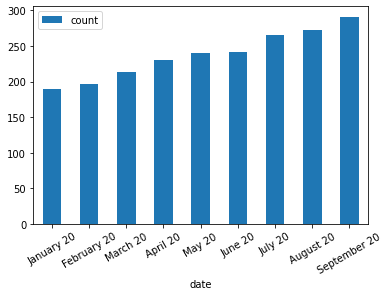

In [ ]:
#@title Active Mr Beam's per month
# Group monthly and leave only 1 row per snr
startup_df['date'] = startup_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)
startup_df = startup_df.drop_duplicates(['snr', 'date'])

mrbeams_month = startup_df.resample('MS', on='date')['snr'].agg(['count'])
print(mrbeams_month)
ax = mrbeams_month.plot(kind='bar')
ax.set_xticklabels(mrbeams_month.index.strftime('%B %y'), rotation=30);

#Current status

In [ ]:
#@title prod_status
def prod_status(datastore_client):
    query = datastore_client.query(kind='status')
    query.add_filter('environment', '=', 'PROD')
 
    return list(query.fetch())

prod_status = prod_status(datastore_client)

In [ ]:
#@title status_df & usage_df & result_df

def extract_sw_versions(row):
  sw_versions = row['software_versions'][0]
  if isinstance(sw_versions, dict):
    for key, value in sw_versions.items():
      row[key] = value.get('version', None)
  return row 

status_df = pd.DataFrame(prod_status)
status_df.groupby('snr')['total_jobs'].apply(list)
status_df.replace(to_replace=[None], value='no_info', inplace=True)

# New column to know if the serial number only uploaded once
status_df['one_upload'] = np.where(status_df['total_uploads']==1, 'one_upload', 'more')

# Datetime from ts
status_df['last_upload'] = pd.to_datetime(status_df['last_upload'], unit='s')

# Add usage columns with data that is inside of [{}] 
usage_df = status_df[status_df['usage']!='no_info'].copy()
# usage_df
usage_df['usage_total_h'] = usage_df['usage'].apply(extract_value_from_data_struct, args=('total',))/3600
usage_df['usage_prefilter_h'] = usage_df['usage'].apply(extract_value_from_data_struct, args=('prefilter',))/3600
usage_df['usage_carbon_filter_h'] = usage_df['usage'].apply(extract_value_from_data_struct, args=('carbon_filter',))/3600
usage_df['usage_laser_head_h'] = usage_df['usage'].apply(extract_value_from_data_struct, args=('laser_head',))/3600
usage_df['usage_gantry_h'] = usage_df['usage'].apply(extract_value_from_data_struct, args=('gantry',))/3600

# software_df
status_df = status_df.apply(extract_sw_versions, axis=1)

# result_df
result_df = status_df[status_df['first_result']!='no_info'].copy()
result_df['complete'] = result_df['first_result'].apply(extract_value_from_data_struct, args=('complete',))
result_df['num_sessions'] = result_df['first_result'].apply(extract_value_from_data_struct, args=('num_sessions',))
result_df['wizard_dur'] = result_df['first_result'].apply(extract_value_from_data_struct, args=('wizard_dur',)) / 60
result_df['result_dur'] = result_df['first_result'].apply(extract_value_from_data_struct, args=('result_dur',)) / 60
result_df['end_ts'] = result_df['first_result'].apply(extract_value_from_data_struct, args=('end_ts',))
result_df['sids'] = result_df['first_result'].apply(extract_value_from_data_struct, args=('sids',))

result_df['date'] = pd.to_datetime(result_df['end_ts'], unit='s')
result_df['date'] = result_df['date'].dt.normalize()
result_df['date'] = result_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)
# result_df = result_df[(result_df['date'] >= FROM_DATE) & (result_df['date'] < TO_DATE)]

result_df = result_df[result_df['complete'] == True]


print('Number of different Mr Beams status: {}'.format(len(status_df)))

Number of different Mr Beams status: 634


###Model

model
MRBEAM2          289
MRBEAM2_DC       237
MRBEAM2_DC_R1     19
no_info           89
Name: model, dtype: int64


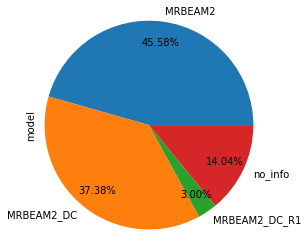

In [ ]:
#@title

model = status_df.groupby(['model'])['model'].count()
print(model)
model.plot.pie(labels=model.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


###UI Language (current)

ui_language
de         379
en         191
es           5
fr          11
it           2
no_info     46
Name: ui_language, dtype: int64


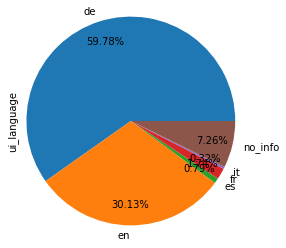

In [ ]:
#@title

languages = status_df.groupby(['ui_language'])['ui_language'].count()
print(languages)
languages.plot.pie(figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


### User agent (current)

os
ChromeOS       3
Linux         54
Macintosh    148
Windows      298
iOS           10
Name: os, dtype: int64 


browser
Chrome            441
ChromeiOS           5
ChromiumEdge       15
Firefox            42
Safari              9
Yandex.Browser      1
Name: browser, dtype: int64 




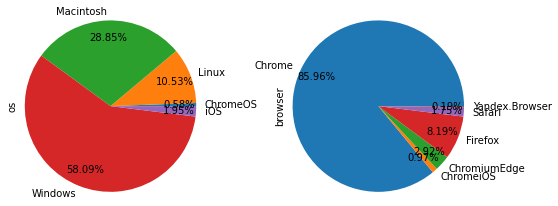

In [ ]:
#@title
def extract_os_browser(row):
  user_agent = httpagentparser.detect(row['user_agent'])
  os = None
  browser = None
  if 'os' in user_agent and 'browser' in user_agent:
    os = user_agent['os']['name']
    browser = user_agent['browser']['name']
  row['os'] = os
  row['browser'] = browser
  return row 

status_df = status_df.apply(extract_os_browser, axis=1)
# status_df.replace(to_replace=[None], value='no_info', inplace=True)

oss = status_df.groupby(['os'])['os'].count()
print(oss, '\n\n')
browsers = status_df.groupby(['browser'])['browser'].count()
print(browsers, '\n\n')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), gridspec_kw={"wspace": .5})
oss.plot.pie(ax=axes[0], radius=1.2, autopct='%1.2f%%', pctdistance=0.8);
browsers.plot.pie(ax=axes[1], radius=1.2, autopct='%1.2f%%', pctdistance=0.8);

###Last upload to Analytics (current)


In [ ]:
#@title
alt.Chart(status_df).mark_point().encode(
  x='last_upload',
  y='total_uploads',
  color='one_upload'
).interactive()

#2019-07-18: v0.3.0 --> The analytics are uploaded after every job

alt.Chart(...)

###Software Channels (current)

sw_tier
BETA        96
PROD       519
no_info     19
Name: sw_tier, dtype: int64


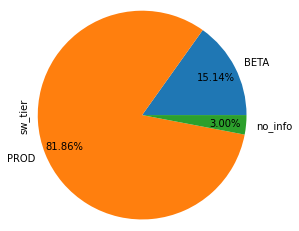

In [ ]:
# @title
channels = status_df.groupby(['sw_tier'])['sw_tier'].count()
print(channels)
channels.plot.pie(labels=channels.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


###MrBeamPlugin version (current)

mrbeam_plugin_version
0.1.60        6
0.2.0        16
0.2.1         1
0.2.2         1
0.3.0         1
0.3.1        19
0.3.2         1
0.4.1         1
0.4.2         6
0.4.3         3
0.4.4         2
0.4.5        13
0.5.0         5
0.5.1        15
0.5.2         1
0.5.3        41
0.5.5         1
0.6.0         6
0.6.1         2
0.6.10        1
0.6.11       10
0.6.12      112
0.6.14        4
0.6.14.1      1
0.6.2        69
0.6.4         2
0.6.7         5
0.6.8         1
0.6.9         2
0.7.0         1
0.7.1        15
0.7.2        45
0.7.3         5
0.7.4        38
0.7.5       162
no_info      20
Name: mrbeam_plugin_version, dtype: int64


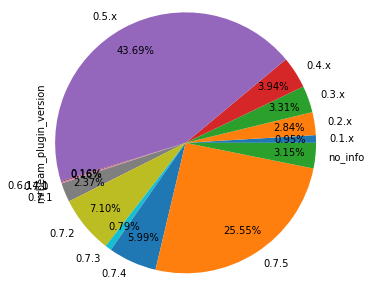

In [ ]:
# @title
mrbplugins = status_df.groupby(['mrbeam_plugin_version'])['mrbeam_plugin_version'].count()
print(mrbplugins)

grouped_v = status_df.copy()
grouped_v.replace(to_replace=['0.1.59', '0.1.60'], value='0.1.x', inplace=True)
grouped_v.replace(to_replace=['0.2.0', '0.2.1', '0.2.2'], value='0.2.x', inplace=True)
grouped_v.replace(to_replace=['0.3.0', '0.3.1', '0.3.2'], value='0.3.x', inplace=True)
grouped_v.replace(to_replace=['0.4.0', '0.4.1', '0.4.2', '0.4.3', '0.4.4', '0.4.5'], value='0.4.x', inplace=True)
grouped_v.replace(to_replace=['0.5.0', '0.5.1', '0.5.2', '0.5.3', '0.5.5', '0.5.6', '0.5.7'], value='0.5.x', inplace=True)
grouped_v.replace(to_replace=['0.6.0', '0.6.1', '0.6.2', '0.6.3', '0.6.4', '0.6.5', '0.6.6', '0.6.7', '0.6.8', '0.6.9', '0.6.10', '0.6.11', '0.6.12', '0.6.13', '0.6.14'], value='0.5.x', inplace=True)


mrbplugins = grouped_v.groupby(['mrbeam_plugin_version'])['mrbeam_plugin_version'].count()

mrbplugins.plot.pie(figsize=(5,5), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);

###iobeam version (current)

iobeam_version
0.4.3        1
0.6.3       12
0.6.4       24
0.6.5        7
0.6.6        7
0.6.7       12
0.7.10      14
0.7.11      91
0.7.12     156
0.7.4        5
0.7.5       59
0.7.6        1
0.7.8       84
0.7.9      121
no_info     40
Name: iobeam_version, dtype: int64


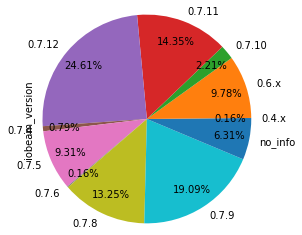

In [ ]:
# @title
iobeams = status_df.groupby(['iobeam_version'])['iobeam_version'].count()
print(iobeams)

grouped_v = status_df.copy()
grouped_v.replace(to_replace=['0.4.3'], value='0.4.x', inplace=True)
grouped_v.replace(to_replace=['0.6.3', '0.6.4', '0.6.5', '0.6.6', '0.6.7'], value='0.6.x', inplace=True)

iobeams = grouped_v.groupby(['iobeam_version'])['iobeam_version'].count()
iobeams.plot.pie(labels=iobeams.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);

### Software versions

In [ ]:
#@title
mrbeam = status_df.groupby(['mrbeam'])['mrbeam'].count()
iobeam = status_df.groupby(['iobeam'])['iobeam'].count()
# octoprint = status_df.groupby(['octoprint'])['octoprint'].count()
findmymrbeam = status_df.groupby(['findmymrbeam'])['findmymrbeam'].count()
netconnectd = status_df.groupby(['netconnectd'])['netconnectd'].count()
mrb_hw_info = status_df.groupby(['mrb_hw_info'])['mrb_hw_info'].count()
ledstrips = status_df.groupby(['mrbeam-ledstrips'])['mrbeam-ledstrips'].count()


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), gridspec_kw={'wspace':0.5})
mrbeam.plot.pie(labels=mrbeam.index.values, ax=axes[0,0], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title="MrBeamPlugin");
iobeam.plot.pie(labels=iobeam.index.values, ax=axes[0,1], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title="IOBeam");
# octoprint.plot.pie(labels=octoprint.index.values, ax=axes[0,2], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title="OctoPrint");
findmymrbeam.plot.pie(labels=findmymrbeam.index.values, ax=axes[0,2], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title='Find My Mrbeam');
netconnectd.plot.pie(labels=netconnectd.index.values, ax=axes[1,0], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title='Netconnectd');
mrb_hw_info.plot.pie(labels=mrb_hw_info.index.values, ax=axes[1,1], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title='mrb_hw_info');
ledstrips.plot.pie(labels=ledstrips.index.values, ax=axes[1,2], radius=1.2, autopct='%1.2f%%', pctdistance=0.8, title='LED Strips');
for ax in axes.flatten():
  ax.title.set_position([.3, 1.05])
  ax.set_ylabel(None)

### Usage (current)

502


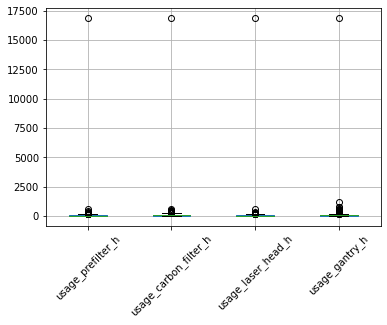

In [ ]:
#@title Components
# (usage_df[['usage_prefilter', 'usage_carbon_filter', 'usage_laser_head', 'usage_gantry']]).describe().transpose()
print(len(usage_df))
boxplot = usage_df.boxplot(column=['usage_prefilter_h', 'usage_carbon_filter_h', 'usage_laser_head_h', 'usage_gantry_h'], rot=45)

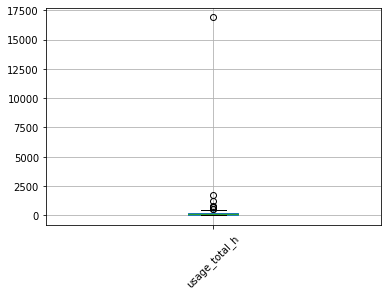

In [ ]:
#@title Total
boxplot = usage_df.boxplot(column=['usage_total_h'], rot=45)

### User accounts

users
0.0      1
1.0    430
2.0     75
3.0     15
4.0      4
5.0      1
6.0      2
7.0      1
Name: users, dtype: int64


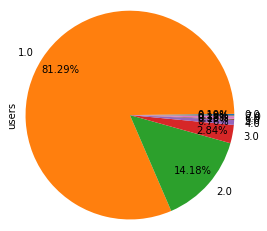

In [ ]:
# @title
users = status_df.groupby(['users'])['users'].count()
print(users)

#plot_me=group_low_values(users, replace_name="other")
users.plot.pie(figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


### SD card

In [ ]:
#@title
alt.Chart(status_df).mark_bar().encode(
    alt.X("used_disk_space_percent:Q", bin=alt.Bin(maxbins=100)),
    y='count()',
)

### First User Experience

Number of samples of 1 session results:
            snr
date           
2019-12-01   10
2020-01-01   11
2020-02-01   10
2020-03-01    6
2020-04-01    8
2020-05-01    9
2020-06-01    4
2020-07-01    8
2020-08-01    3
2020-09-01    2

Number of samples of multiple session results:
            snr
date           
2020-02-01    1
2020-03-01    7
2020-04-01   12
2020-05-01   12
2020-06-01   16
2020-07-01   12
2020-08-01   14
2020-09-01   16

Total number of samples:
            snr
date           
2019-12-01   10
2020-01-01   11
2020-02-01   11
2020-03-01   13
2020-04-01   20
2020-05-01   21
2020-06-01   20
2020-07-01   20
2020-08-01   17
2020-09-01   18


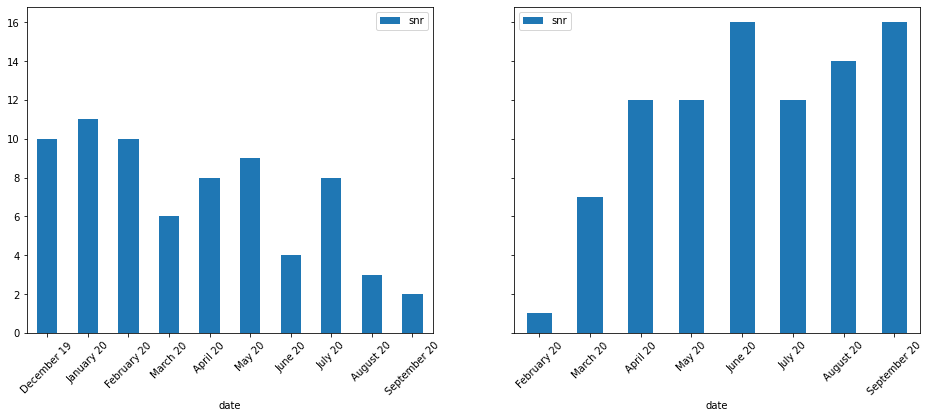

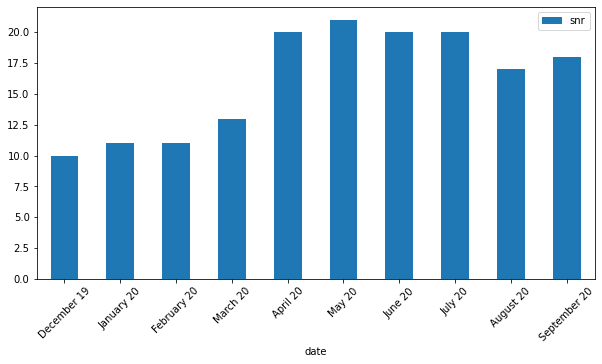

In [ ]:
#@title Number of samples
num_one = result_df[result_df['num_sessions'] == 1].groupby('date').count()
num_multiple = result_df[result_df['num_sessions'] != 1].groupby('date').count()
num_total = result_df.groupby('date').count()

print('Number of samples of 1 session results:')
print(num_one[['snr']])
print('\nNumber of samples of multiple session results:')
print(num_multiple[['snr']])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

num_one[['snr']].plot.bar(ax=ax1);
num_multiple[['snr']].plot.bar(ax=ax2);

ax1.set_xticklabels(num_one.index.strftime("%B %y"), rotation=45);
ax2.set_xticklabels(num_multiple.index.strftime("%B %y"), rotation=45);

print('\nTotal number of samples:')
print(num_total[['snr']])

ax = num_total[['snr']].plot.bar(figsize=(10,5))
ax.set_xticklabels(num_total.index.strftime("%B %y"), rotation=45);


Mean wizard duration for 1 session results:
            wizard_dur
date                  
2019-12-01    7.572133
2020-01-01   15.277485
2020-02-01   11.985083
2020-03-01    5.594028
2020-04-01    4.119479
2020-05-01    9.908167
2020-06-01    4.401417
2020-07-01    6.287417
2020-08-01    3.613444
2020-09-01   10.916333

Mean wizard duration for multiple session results:
            wizard_dur
date                  
2020-02-01    6.343667
2020-03-01    8.777095
2020-04-01    6.743431
2020-05-01    6.824792
2020-06-01    6.140521
2020-07-01    4.765028
2020-08-01   15.114036
2020-09-01    9.260521

Total mean wizard duration:
            wizard_dur
date                  
2019-12-01    7.572133
2020-01-01   15.277485
2020-02-01   11.472227
2020-03-01    7.307987
2020-04-01    5.693850
2020-05-01    8.146238
2020-06-01    5.792700
2020-07-01    5.373983
2020-08-01   13.084520
2020-09-01    9.444500


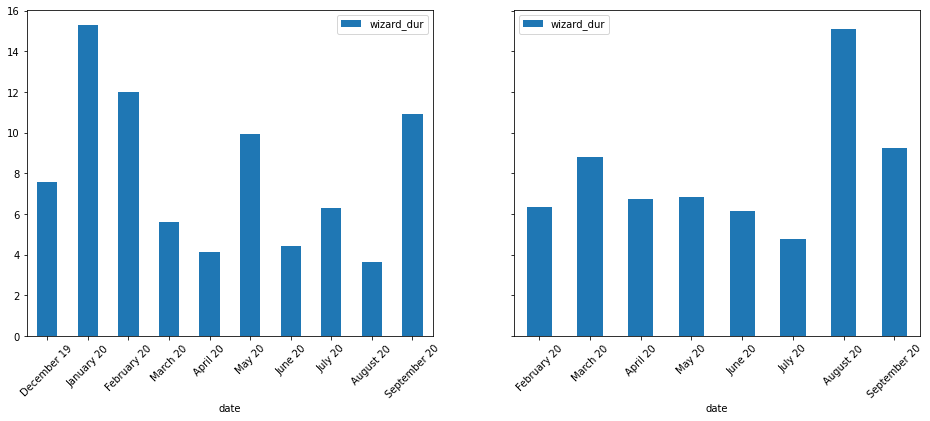

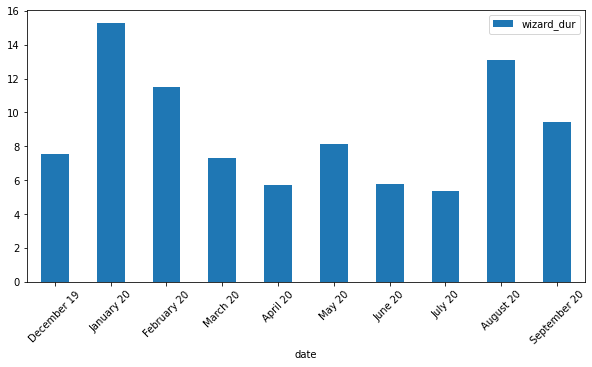

In [ ]:
#@title Mean welcome dialog duration
wiz_dur_one = result_df[result_df['num_sessions'] == 1].groupby('date').mean()
wiz_dur_multiple = result_df[result_df['num_sessions'] != 1].groupby('date').mean()
wiz_dur_total = result_df.groupby('date').mean()


print('Mean wizard duration for 1 session results:')
print(wiz_dur_one[['wizard_dur']])
print('\nMean wizard duration for multiple session results:')
print(wiz_dur_multiple[['wizard_dur']])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

wiz_dur_one[['wizard_dur']].plot.bar(ax=ax1);
wiz_dur_multiple[['wizard_dur']].plot.bar(ax=ax2);

ax1.set_xticklabels(wiz_dur_one.index.strftime("%B %y"), rotation=45);
ax2.set_xticklabels(wiz_dur_multiple.index.strftime("%B %y"), rotation=45);

print('\nTotal mean wizard duration:')
print(wiz_dur_total[['wizard_dur']])

ax = wiz_dur_total[['wizard_dur']].plot.bar(figsize=(10,5))
ax.set_xticklabels(wiz_dur_total.index.strftime("%B %y"), rotation=45);

Mean first result duration for 1 session results:
            result_dur
date                  
2019-12-01   24.525667
2020-01-01   35.198455
2020-02-01   62.182700
2020-03-01   26.039889
2020-04-01   51.647917
2020-05-01   22.249722
2020-06-01   27.046917
2020-07-01   27.288646
2020-08-01   50.949944
2020-09-01   44.783250

Mean first result duration for multiple session results:
            result_dur
date                  
2020-02-01  190.936667
2020-03-01   43.697262
2020-04-01  145.315917
2020-05-01   62.764792
2020-06-01  152.746052
2020-07-01   31.127181
2020-08-01   86.984417
2020-09-01   74.224000

Total mean first result duration:
            result_dur
date                  
2019-12-01   24.525667
2020-01-01   35.198455
2020-02-01   73.887606
2020-03-01   35.547705
2020-04-01  107.848717
2020-05-01   45.401190
2020-06-01  127.606225
2020-07-01   29.591767
2020-08-01   80.625392
2020-09-01   70.952806


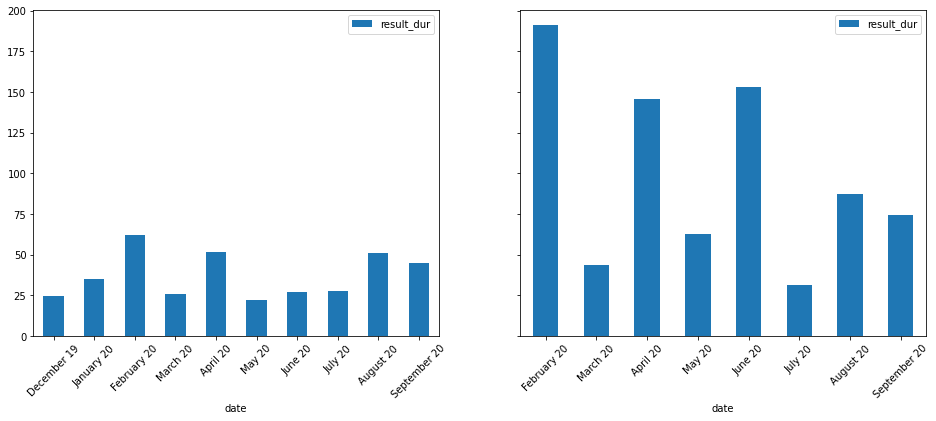

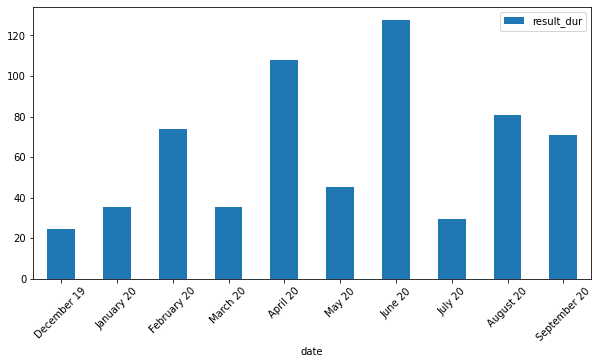

In [ ]:
#@title Mean first result duration
res_dur_one = result_df[result_df['num_sessions'] == 1].groupby('date').mean()
res_dur_multiple = result_df[result_df['num_sessions'] != 1].groupby('date').mean()
res_dur_total = result_df.groupby('date').mean()


print('Mean first result duration for 1 session results:')
print(res_dur_one[['result_dur']])
print('\nMean first result duration for multiple session results:')
print(res_dur_multiple[['result_dur']])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

res_dur_one[['result_dur']].plot.bar(ax=ax1);
res_dur_multiple[['result_dur']].plot.bar(ax=ax2);

ax1.set_xticklabels(res_dur_one.index.strftime("%B %y"), rotation=45);
ax2.set_xticklabels(res_dur_multiple.index.strftime("%B %y"), rotation=45);

print('\nTotal mean first result duration:')
print(res_dur_total[['result_dur']])

ax = res_dur_total[['result_dur']].plot.bar(figsize=(10,5))
ax.set_xticklabels(res_dur_total.index.strftime("%B %y"), rotation=45);

num_sessions
1     71
2     45
3     21
4      6
5      3
7      3
8      3
9      2
11     2
15     1
16     1
18     1
20     1
29     1
Name: num_sessions, dtype: int64


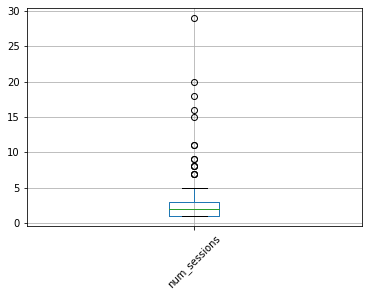

In [ ]:
#@title Number of sessions
num_sessions = result_df.groupby(['num_sessions'])['num_sessions'].count()
print(num_sessions)
boxplot = result_df.boxplot(column=['num_sessions'], rot=45)

# Laser heads (wip)

In [ ]:
#@title

## See prod_device_startup

# def prod_laserhead_avail(datastore_client):
#     query = datastore_client.query(kind='device')
#     query.add_filter('e', '=', 'startup')
#     query.add_filter('environment', '=', 'PROD')
#     return list(query.fetch()) 

# devices = prod_laserhead_avail(datastore_client)
# printsize(devices)

devices: 401, sessions: 1622, ok: 327, fail: 31, mixed: 43


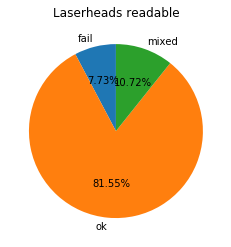

In [ ]:
#@title


devices = startup_df

out = dict()

def lh_serial(data):
  if type(data) is list:
    return data[0]['laserhead_serial'] or 'na'
  else:
    return 'na'
# 
devices['laserhead'] = devices['data'].apply(lh_serial)
c_sessions = len(devices[devices['version'] >= 3])
for snr, deviceGroup in devices[devices['version'] >= 3].groupby('snr'):
  out[snr] = {laserHead: count for laserHead, count in deviceGroup['laserhead'].value_counts().items()}
# for d in devices[devices['version'] >= 3]:
#   c_sessions += 1
#   snr = d['snr']
#   lsn = d['data'][0]['laserhead_serial'] or 'na'
#   if not snr in out:
#     out[snr] = dict()
#   if not lsn in out[snr]:
#       out[snr][lsn] = 0
#   out[snr][lsn] += 1

res = dict(fail = 0, ok=0, mixed=0)
for k,v in out.items():
  if len(v.keys()) > 1 and 'na' in v:
    res['mixed'] += 1
  elif 'na' in v:
    res['fail'] += 1
  else:
    res['ok'] += 1
    
    
print("devices: {}, sessions: {}, ok: {}, fail: {}, mixed: {}".format(len(out), c_sessions, res['ok'], res['fail'], res['mixed']) )

labels = res.keys()
sections = res.values()

plt.pie(sections, labels=labels, startangle=90,
#         autopct="%i pcs"
#         explode = (0, 0.05, 0.05),
        autopct = '%1.2f%%'
       )

plt.title('Laserheads readable')
plt.show()

### Laser power correction

In [ ]:
#@title prod_laserhead_info
# def prod_laserhead_info_query(datastore_client):
#     query = datastore_client.query(kind='device')
#     query.add_filter('e', '=', 'laserhead_info')
#     query.add_filter('environment', '=', 'PROD')
#     return list(query.fetch()) 
if 'prod_laserhead_info' not in locals().keys():
  # prod_laserhead_info = prod_laserhead_info_query(datastore_client)
  prod_laserhead_info = simple_query(datastore_client, 
                                     kind='device',
                                     e='laserhead_info').fetch()

In [ ]:
#@title lh_df

lh_df = pd.DataFrame(prod_laserhead_info)

# Apply timeframe and get date from ts
lh_df['date'] = pd.to_datetime(lh_df['ts'], unit='s')
lh_df = lh_df[(lh_df['date'] > FROM_DATE) & (lh_df['date'] < TO_DATE)]
lh_df['date'] = lh_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
lh_df['correction_factor'] = lh_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('correction_factor'))
lh_df['serial'] = lh_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('laserhead_serial'))

# Only take latest for each serial, and check if there is a correction factor
lh_df = lh_df.sort_values(by=['ts'], ascending=False).drop_duplicates(subset=['serial'])
lh_df['correction_applied'] = np.where(lh_df['correction_factor']==1, False, True)

#@title Fan rpm values in test
print('Number of different laser heads: {}'.format(len(lh_df)))

Number of different laser heads: 335


   correction_applied  num_lh
0               False     319
1                True      16


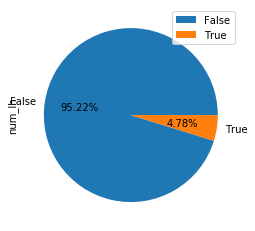

In [ ]:
#@title Correction factor applied
result_overall = lh_df.groupby(['correction_applied']).size().reset_index(name='num_lh')

print(result_overall)
plot = result_overall.plot.pie(y='num_lh', labels=result_overall['correction_applied'], autopct='%1.2f%%')

In [ ]:
#@title Correction factors
with_correction = lh_df.loc[lh_df['correction_factor'] != 1]

alt.Chart(with_correction).mark_bar().encode(
    alt.X("correction_factor:Q", bin=alt.Bin(maxbins=50)),
    y='count()',
)

alt.Chart(...)

In [ ]:
printsize(lh_df)
del lh_df

342.08 kB


# Jobs

###Job history (current --> uses status_df)

In [ ]:
#@title
# Get all job ts in a list
all_jobs = status_df['total_jobs'].tolist()
flatten = functools.reduce(operator.concat, all_jobs)
all_jobs_df = pd.DataFrame(flatten, columns=['date'])

# Filter for the timeframe
all_jobs_df['date'] = pd.to_datetime(all_jobs_df['date'], unit='s')
filtered_jobs_df = all_jobs_df[(all_jobs_df['date'] > FROM_DATE) & (all_jobs_df['date'] < TO_DATE)]

print('Number of jobs between {} and {}'.format(FROM_DATE, TO_DATE, len(filtered_jobs_df)))

# Count number of jobs per day
jobs_per_day_df = filtered_jobs_df.groupby(filtered_jobs_df['date'].dt.normalize()).size().reset_index(name='num_jobs')

# Plot
alt.Chart(jobs_per_day_df).mark_line().encode(
  x='date',
  y='num_jobs',
).interactive(bind_y=False)

Number of jobs between 2020-01-01 00:00:00 and 2020-09-28 06:21:42.998724


alt.Chart(...)

### Job success

In [ ]:
# This query works a bit differently, as we filter for the ts and only discard the DEV jobs later in the dataframe --> Should be faster
from_ts = time.mktime(date.today().replace(day=1).replace(month=1).timetuple())  # First day of year, 00:00
to_ts = time.time()  # Today

In [ ]:
#@title Query: job_object (not only prod)

def job_object_query(datastore_client):
  query = datastore_client.query(kind='jobObject')
  query.add_filter('ts', '>=', from_ts)
  query.add_filter('ts', '<=', to_ts)
  
  return list(query.fetch())

job_object = job_object_query(datastore_client)


In [ ]:
#@title jobs_df
jobs_df = pd.DataFrame(job_object)
jobs_df = jobs_df[(jobs_df['environment'] == 'PROD')]

# Apply timeframe and get date from ts
jobs_df['date'] = pd.to_datetime(jobs_df['ts'], unit='s')
jobs_df['date'] = jobs_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
jobs_df['result_status'] = jobs_df['result'].apply(operator.itemgetter(0)).apply(operator.itemgetter('status'))
jobs_df['result_duration'] = jobs_df['result'].apply(operator.itemgetter(0)).apply(operator.itemgetter('duration'))

jobs_df.replace(to_replace=[None], value='unknown', inplace=True)

# Number of different Mr Beams for this timeframe
num_snr = jobs_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

# TEMPORARY BUG FIX: job_ids come twice, as the slicing is saved separately
jobs_df = jobs_df.sort_values(by=['ts'], ascending=False).drop_duplicates(subset=['job_id'])

Number of different Mr Beams for this timeframe: 532


In [ ]:
#@title Save to Drive (for DataStudio)
jobs_datastudio_df = jobs_df[['date', 'result_status', 'result_duration']].copy()
jobs_datastudio_df['count'] = 1

gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1KShDpB6dRLQlVt6ZoQ8-f--NrOUZnZgShJXH9zuEMiI/edit#gid=0').sheet1

worksheet.clear()

set_with_dataframe(worksheet, jobs_datastudio_df)

In [ ]:
# @title Job success per day

result_per_day = jobs_df.groupby(['date','result_status']).size().reset_index(name='num_jobs')
alt.Chart(result_per_day).mark_line().encode(
  x='date',
  y='num_jobs',
  color='result_status'
).interactive(bind_y=False).properties(
    width=600,
    height=300
) #bind_y=False

alt.Chart(...)

  result_status  num_jobs
0     Cancelled      6956
1          Done     46134
2        Failed       248
3        Sliced      7278
4       unknown      1841


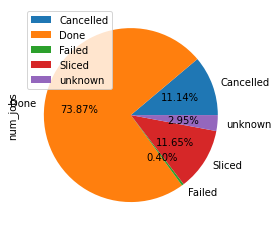

In [ ]:
#@title Overall job success
result_overall = jobs_df.groupby(['result_status']).size().reset_index(name='num_jobs')

print(result_overall)
result_overall.plot.pie(y='num_jobs', labels=result_overall['result_status'], autopct='%1.2f%%')

### Failed jobs

In [ ]:
#@title prod_job_p_failed

def prod_job_p_failed(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'p_failed')
  
  return list(query.fetch())

prod_job_p_failed = prod_job_p_failed(datastore_client)


In [ ]:
#@title failed_df
ERROR_MSGS = ['GRBL: error: Expected command letter',
              'GRBL: error: Undefined feed rate',
              'GRBL: alarm message',
              'GRBL: error: Unsupported command',
              'GRBL: error: Not idle',
              'GRBL: error: Alarm lock',
              'GRBL: error: Invalid gcode'
]

failed_df = pd.DataFrame(prod_job_p_failed)

# Apply timeframe and get date from ts
failed_df['date'] = pd.to_datetime(failed_df['ts'], unit='s')
failed_df = failed_df[(failed_df['date'] > FROM_DATE) & (failed_df['date'] < TO_DATE)]
failed_df['date'] = failed_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
failed_df['error'] = failed_df['data'].apply(extract_value_from_data_struct, args=('err',))

# Replace 
for msg in ERROR_MSGS:
  failed_df.loc[failed_df['error'].str.contains(msg), 'error'] = msg


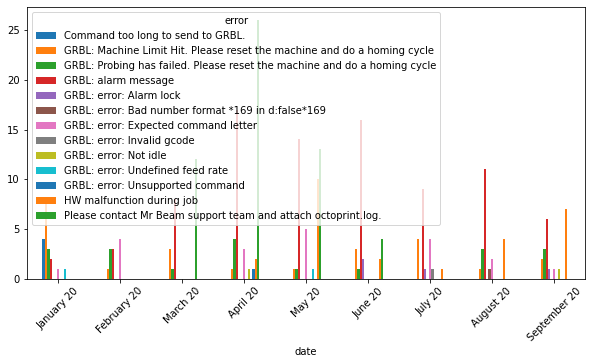

In [ ]:
#@title Monthly failure errors

monthly_df = failed_df.copy()
monthly_df['date'] = monthly_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)


failed_crosstab = pd.crosstab(monthly_df['date'],monthly_df['error'])
#print('\n')
ax = failed_crosstab.plot.bar(figsize=(10,5))
ax.set_xticklabels(failed_crosstab.index.strftime("%B %y"), rotation=45);

###Number of jobs and durations

result_status  Cancelled  Done  Failed  Sliced  unknown  Total
date                                                          
2020-01-01           543  3095      28     527      165   4358
2020-02-01           697  4036      12     615      190   5550
2020-03-01           667  4129      28     695      184   5703
2020-04-01           967  5929      52     879      216   8043
2020-05-01          1027  5932      40     917      284   8200
2020-06-01           733  5717      27     841      257   7575
2020-07-01           844  5515      20     924      169   7472
2020-08-01           637  5425      22     775      110   6969
2020-09-01           841  6356      19    1105      266   8587




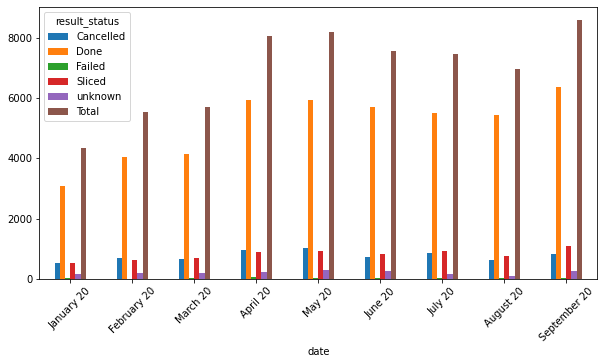

In [ ]:
# @title Number of jobs per month
monthly_df = jobs_df.copy()
monthly_df['date'] = monthly_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)


jobs_crosstab = pd.crosstab(monthly_df['date'],jobs_df['result_status'])
jobs_crosstab['Total'] = jobs_crosstab['Cancelled'] + jobs_crosstab['Done'] + jobs_crosstab['Failed'] + jobs_crosstab['Sliced'] + jobs_crosstab['unknown']
print(jobs_crosstab)
print('\n')
ax = jobs_crosstab.plot.bar(figsize=(10,5))
ax.set_xticklabels(jobs_crosstab.index.strftime("%B %y"), rotation=45);

            laser_hours
date                   
2020-01-01  1308.393250
2020-02-01  1317.677500
2020-03-01  1936.428556
2020-04-01  2381.020028
2020-05-01  3280.791944
2020-06-01  3767.432667
2020-07-01  3720.859778
2020-08-01  3136.380750
2020-09-01  3916.897694


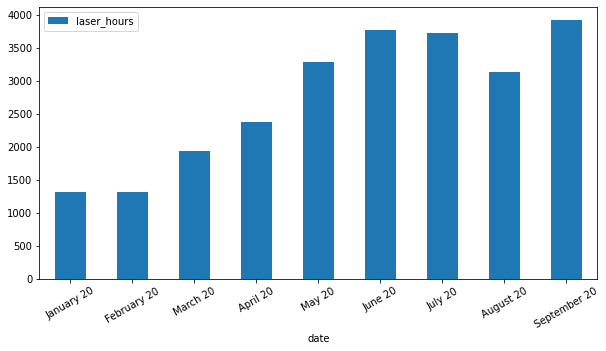

In [ ]:
# @title Laser hours per month
durations_month = jobs_df.resample('MS', on='date')['result_duration'].agg(['sum'])
durations_month.columns = ['laser_hours']

durations_month['laser_hours'] = durations_month['laser_hours'].div(3600)
print(durations_month)

ax = durations_month.plot(kind='bar', figsize=(10,5))
ax.set_xticklabels(durations_month.index.strftime('%B %y'), rotation=30);

### Job finished per weekday

In [ ]:
#@title prod_job_done_dialog
def prod_job_done_dialog_query(datastore_client):
  query = datastore_client.query(kind='frontend')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'job_done_dialog')
  
  return list(query.fetch())

if 'prod_job_done_dialog' not in locals().keys():
  prod_job_done_dialog = prod_job_done_dialog_query(datastore_client)

In [ ]:
#@title done_dialog_df
def substract_dialog_dur(row):
  # print(row)
  return row['browser_time']
  # return row['browser_time'] - timedelta(seconds=row['dur'])

done_dialog_df = pd.DataFrame(prod_job_done_dialog)

# Apply timeframe and get date from ts
done_dialog_df['date'] = pd.to_datetime(done_dialog_df['ts'], unit='s')
done_dialog_df = done_dialog_df[(done_dialog_df['date'] > FROM_DATE) & (done_dialog_df['date'] < datetime.now())]
done_dialog_df['date'] = done_dialog_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
done_dialog_df['browser_time'] = done_dialog_df['data'].apply(extract_value_from_data_struct, args=('browser_time',))
done_dialog_df = done_dialog_df[done_dialog_df['browser_time'].notnull()]
done_dialog_df['dur'] = done_dialog_df['data'].apply(extract_value_from_data_struct, args=('dur',))

# Extract the date from the browser_time string
done_dialog_df['browser_time'] = done_dialog_df['browser_time'].map(parser.parse)

# Substract the duration of the didalog (because the browser time is from the moment that it was closed, not shown)
done_dialog_df['dur'] = pd.to_timedelta(done_dialog_df['dur'],'s')
done_dialog_df['browser_time'] = done_dialog_df['browser_time'] - done_dialog_df['dur']

done_dialog_df['browser_weekday'] = done_dialog_df['browser_time'].dt.day_name()

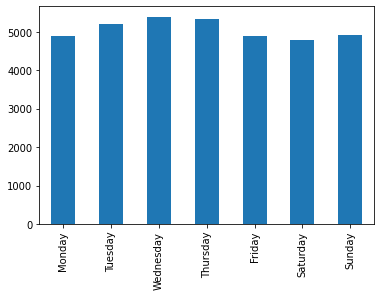

In [ ]:
#@title
done_dialog_df['browser_weekday'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot.bar()

### Jobs per device per month

            num_devices  num_done_jobs  jobs_per_device
date                                                   
2020-01-01          178           3095        17.387640
2020-02-01          188           4036        21.468085
2020-03-01          192           4129        21.505208
2020-04-01          220           5929        26.950000
2020-05-01          231           5932        25.679654
2020-06-01          225           5717        25.408889
2020-07-01          253           5515        21.798419
2020-08-01          258           5425        21.027132
2020-09-01          266           6356        23.894737


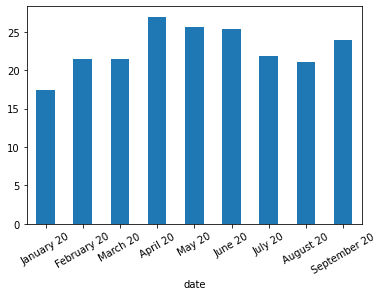

In [ ]:
#@title
devices_month = jobs_df.resample('MS', on='date')['snr'].nunique()# ['result_duration'].agg(['sum'])
jobs_month = jobs_df.loc[jobs_df['result_status'] == 'Done'].resample('MS', on='date')['snr'].count()# ['result_duration'].agg(['sum'])
jobs_device_df = pd.concat([devices_month.rename('num_devices'), jobs_month.rename('num_done_jobs')], axis=1)

jobs_device_df['jobs_per_device'] = jobs_device_df['num_done_jobs'] / jobs_device_df['num_devices']

print(jobs_device_df)
ax = jobs_device_df['jobs_per_device'].plot(kind='bar')
ax.set_xticklabels(jobs_device_df.index.strftime('%B %y'), rotation=30);

### Active days per device per month

            active_days
date                   
2020-01-01     4.917098
2020-02-01     5.326633
2020-03-01     5.699074
2020-04-01     6.434043
2020-05-01     6.307377
2020-06-01     6.040984
2020-07-01     5.749077
2020-08-01     5.946237
2020-09-01     6.114865


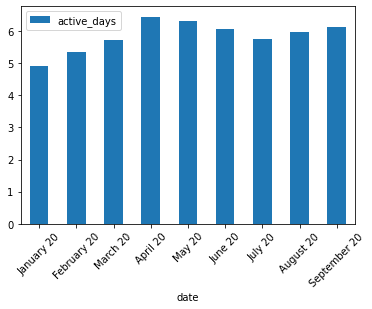

In [ ]:
#@title
# Take jobs and startup events into account
active_df = jobs_df.copy().append(startup_df, ignore_index=True)

# Set the snr+date combination as index
active_df['snr_date'] = active_df['snr'] + active_df['date'].astype(str)
active_df.set_index('snr_date', drop=True, inplace=True)
active_df = active_df.loc[~active_df.index.duplicated(keep='first')]

# Change date to months and count the number of occurrences (that is the number of different days in the same month)
active_df['date'] = active_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)
active_days_snr = active_df.groupby(['snr', 'date'])['date'].count().reset_index(name='active_days')

# Calculate the mean of the active days
active_days_month = active_days_snr.groupby('date').mean()
print(active_days_month)

# Chart
ax = active_days_month[['active_days']].plot.bar()
ax.set_xticklabels(active_days_month.index.strftime("%B %y"), rotation=45);


###Job parameters

In [ ]:
#@title cut_df & eng_df

items_df = jobs_df.explode('job_items')
items_df = items_df[~items_df['job_items'].isnull()]
extract_df = pd.json_normalize(items_df['job_items'])

####Cutting

In [ ]:
#@title cut_df
cut_df = extract_df[extract_df['e'] == 'conv_cut']

data.progressive
False    8211
True      886
Name: data.progressive, dtype: int64


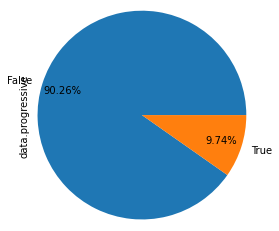

In [ ]:
#@title Progressive cut
progressive = cut_df.groupby(['data.progressive'])['data.progressive'].count()
print(progressive)
progressive.plot.pie(labels=progressive.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


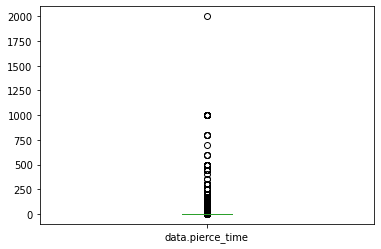

In [ ]:
#@title Pierce time
pd.to_numeric(cut_df['data.pierce_time']).plot.box()

data.engrave
False    39089
True      9253
Name: data.engrave, dtype: int64


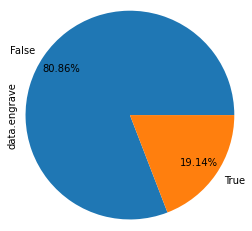

In [ ]:
#@title Moved to "engrave"
engrave = cut_df.groupby(['data.engrave'])['data.engrave'].count()
print(engrave)
engrave.plot.pie(labels=engrave.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


####Engraving

In [ ]:
#@title eng_df
eng_df = extract_df[extract_df['e'] == 'conv_eng']

data.dithering
False    34811
True      1541
Name: data.dithering, dtype: int64


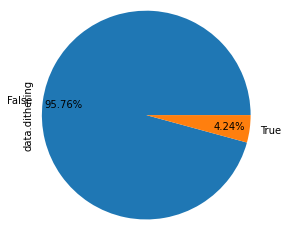

In [ ]:
#@title Dithering
dithering = eng_df.groupby(['data.dithering'])['data.dithering'].count()
print(dithering)
dithering.plot.pie(labels=dithering.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


data.engraving_mode
basic       3252
fast         533
precise    32567
Name: data.engraving_mode, dtype: int64


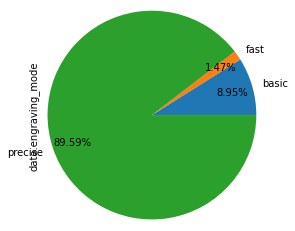

In [ ]:
#@title Engraving mode
engraving_mode = eng_df.groupby(['data.engraving_mode'])['data.engraving_mode'].count()
print(engraving_mode)
engraving_mode.plot.pie(labels=engraving_mode.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);


###NTP sync during job

In [ ]:
#@title prod_ntp_sync

def prod_ntp_sync(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'ntp_sync')
  return list(query.fetch())

prod_ntp_sync = prod_ntp_sync(datastore_client)

In [ ]:
#@title ntp_df
ntp_df = pd.DataFrame(prod_ntp_sync)

# Apply timeframe and get date from ts
ntp_df['date'] = pd.to_datetime(ntp_df['ts'], unit='s')
ntp_df = ntp_df[(ntp_df['date'] > FROM_DATE) & (ntp_df['date'] < TO_DATE)]
ntp_df['date'] = ntp_df['date'].dt.normalize()

# Extract values from data
ntp_df['time_shift'] = ntp_df['data'].apply(extract_value_from_data_struct, args=('time_shift',)) / 3600
ntp_df['job_duration_after'] = ntp_df['data'].apply(extract_value_from_data_struct, args=('job_duration_after',)) / 3600
ntp_df['job_duration_before'] = ntp_df['data'].apply(extract_value_from_data_struct, args=('job_duration_before',)) / 3600

# Number of different Mr Beams for this timeframe
num_snr = ntp_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))


Number of different Mr Beams for this timeframe: 5


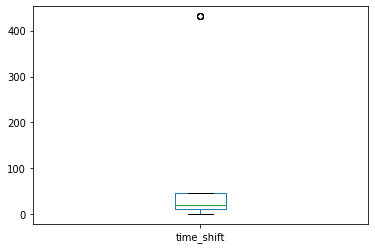

In [ ]:
# The values are in hours
pd.to_numeric(ntp_df['time_shift']).plot.box()

In [ ]:
ntp_df[['snr', 'time_shift', 'job_duration_before', 'job_duration_after']]

snr  time_shift  job_duration_before  job_duration_after
0   000000005CDDF497-2U   20.575854            21.167274            0.591419
1   00000000F2C67736-2U   45.218055            45.970260            0.752205
2   000000005CDDF497-2U   20.575854            20.859635            0.283781
3   00000000F2C67736-2U   11.776413            12.639879            0.863467
4   00000000DE4C1993-2U   34.508788             0.068899          -34.439889
5   00000000F2C67736-2U   11.776413            12.229331            0.452918
6   000000009991DC83-2U  431.430532           431.928441            0.497909
7   000000005CDDF497-2U   20.575854            21.103881            0.528027
8   00000000F2C67736-2U   11.776413            12.542069            0.765657
9   0000000010EEACFB-2D    0.000003             0.000089            0.000087
10  0000000010EEACFB-2D    0.000003             0.025812            0.025809
11  00000000F2C67736-2U   11.776413            12.358759            0.582346
12  00000000F2C67736-2U   45.218055            47.141131            1.923075
13  00000000DE4C1993-2U   34.508788             0.060332          -34.448456
14  000000005CDDF497-2U   20.575854            20.832969            0.257114
15  00000000F2C67736-2U   45.218055            46.847400            1.629345
16  00000000F2C67736-2U   45.218055            46.283757            1.065702
17  00000000DE4C1993-2U   34.508788             0.086452          -34.422336
18  00000000DE4C1993-2U   34.508788             0.052047          -34.456741
19  00000000F2C67736-2U   11.776413            12.121054            0.344642
20  000000005CDDF497-2U   20.575854            20.886031            0.310177
21  00000000F2C67736-2U   45.218055            46.116214            0.898159
22  00000000F2C67736-2U   45.218055            46.474446            1.256391
23  00000000DE4C1993-2U   34.508788             0.077746          -34.431042
24  00000000F2C67736-2U   11.776413            12.847776            1.071363
25  000000005CDDF497-2U   20.575854            21.074479            0.498624
26  00000000F2C67736-2U   11.776413            12.235769            0.459356
27  0000000010EEACFB-2D    0.000003             0.001259            0.001257
28  000000005CDDF497-2U   20.575854            21.047888            0.472034
29  0000000010EEACFB-2D    0.000003             0.000226            0.000224
30  00000000F2C67736-2U   35.856927             0.032739          -35.824188
31  00000000F2C67736-2U   35.856927             0.039545          -35.817382
32  000000009991DC83-2U  431.430532           431.979597            0.549065
33  0000000010EEACFB-2D    0.000003             0.000086            0.000083
34  00000000F2C67736-2U   11.776413            12.652331            0.875919
35  000000009991DC83-2U  431.430532           431.979632            0.549099
36  00000000F2C67736-2U   11.776413            12.447189            0.670777
37  00000000F2C67736-2U   45.218055            45.778352            0.560297
38  00000000F2C67736-2U   35.856927             0.025340          -35.831587
39  00000000F2C67736-2U   45.218055            46.672344            1.454289
40  00000000F2C67736-2U   35.856927             0.042584          -35.814343
41  0000000010EEACFB-2D    0.000003             0.013524            0.013522
42  00000000F2C67736-2U   35.856927             0.014128          -35.842800
43  000000005CDDF497-2U   20.575854            21.022392            0.446538
44  00000000F2C67736-2U   45.218055            46.074583            0.856527
45  000000009991DC83-2U  431.430532           431.820778            0.390246
46  00000000F2C67736-2U   11.776413            12.952061            1.175649
47  00000000F2C67736-2U   35.856927             0.017683          -35.839244
48  000000009991DC83-2U  431.430532           431.875098            0.444566
49  00000000F2C67736-2U   11.776413            12.952182            1.175770
50  00000000F2C67736-2U   11.776413            12.743398            0.966985
51  00000000DE4C

### Job time estimation (refactor code!)

In [ ]:
#@title prod_job_done

def prod_job_done_query(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'p_done')

  return list(query.fetch())

prod_job_done = prod_job_done_query(datastore_client)

Wrong estimations (> 200%): 44 -- From 44 SNRs

Number of estimations
<=1 min: 5977
<30 min: 22998
<1 h: 2821
<2 h: 1828
<4 h: 1004
>4 h: 455
no data (gcode): 1485


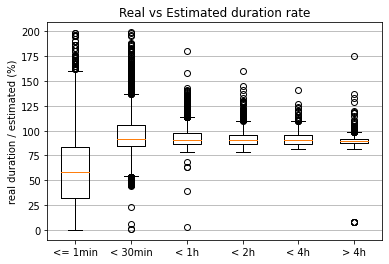

In [ ]:
#@title

wrong = 0
no_data = 0
less_1min = np.array([])
less_30min = np.array([])
less_1h = np.array([])
less_2h = np.array([])
less_4h = np.array([])
more_4h = np.array([])

err_snrs = []

# CALCULATE PERIODS
for done in prod_job_done:
  if 'data' in done:
    if 'dur_est' in done['data'][0]:
      estimation = done['data'][0]['dur_est']
      duration = done['data'][0]['dur']
      percent = duration/estimation*100
      if estimation!= -1 and (percent > 200 or percent < 0):
        if done['snr'] not in err_snrs:
          wrong += 1
          err_snrs.append(done['snr'])
      else:
        if estimation == -1:
          no_data += 1
        elif estimation == 1 * 60:
          less_1min = np.append(less_1min, percent)
        elif estimation < 30 * 60:
          less_30min = np.append(less_30min, percent)
        elif estimation < 1 * 3600:
          less_1h = np.append(less_1h, percent)
        elif estimation < 2 * 3600:
          less_2h = np.append(less_2h, percent)
        elif estimation < 4 * 3600:
          less_4h = np.append(less_4h, percent)
        else:
          more_4h = np.append(more_4h, percent)

print("Wrong estimations (> 200%): {} -- From {} SNRs".format(wrong, len(set(err_snrs))))

print("\nNumber of estimations")
print("<=1 min: {}".format(less_1min.size))
print("<30 min: {}".format(less_30min.size))
print("<1 h: {}".format(less_1h.size))
print("<2 h: {}".format(less_2h.size))
print("<4 h: {}".format(less_4h.size))
print(">4 h: {}".format(more_4h.size))
print("no data (gcode): {}".format(no_data))

# CALCULATE STATS
periods = ['<= 1min', '< 30min', '< 1h', '< 2h', '< 4h', '> 4h']


# PLOT
fig, ax = plt.subplots()
ax.boxplot([less_1min, less_30min, less_1h, less_2h, less_4h, more_4h])
ax.set_ylabel('real duration / estimated (%)')
ax.set_xticklabels(periods)
ax.set_title('Real vs Estimated duration rate')
ax.yaxis.grid(True)

plt.show()

In [ ]:
#@title prod_job_time_estimated

def prod_job_time_estimated(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'job_time_estimated')

  return list(query.fetch())

prod_job_time_estimated = prod_job_time_estimated(datastore_client)

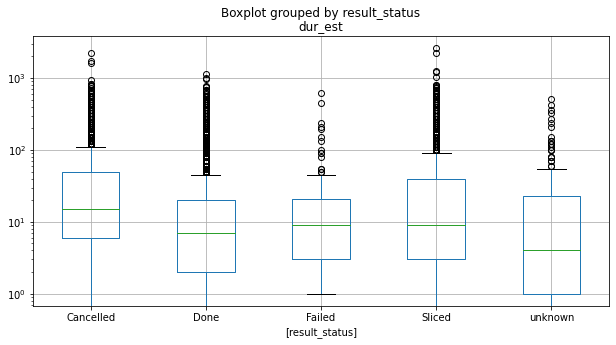

In [ ]:
#@title est_result_df
estimated_df = pd.DataFrame(prod_job_time_estimated)

# Apply timeframe and get date from ts
estimated_df['date'] = pd.to_datetime(estimated_df['ts'], unit='s')
estimated_df = estimated_df[(estimated_df['date'] > FROM_DATE) & (estimated_df['date'] < datetime.now())]
estimated_df['date'] = estimated_df['date'].dt.normalize()
estimated_df['dur_est'] = estimated_df['data'].apply(extract_value_from_data_struct, args=('dur_est',))

estimated_df.set_index('job_id', drop=True, inplace=True)
estimated_df = estimated_df.loc[~estimated_df.index.duplicated(keep='first')]


jobs_2_df = jobs_df.copy()
jobs_2_df.set_index('job_id', drop=True, inplace=True)
jobs_2_df = jobs_2_df.loc[~jobs_2_df.index.duplicated(keep='last')]


# Combine in new a dataframe the jobs and the estimations
est_result_df = pd.concat([
                         estimated_df[['dur_est']], #.astype('float'), 
                         jobs_2_df[['result_status']]], 
                         axis=1, sort=False).reset_index()

# Only keep the jobs that have the estimation info
est_result_df = est_result_df[est_result_df['dur_est'].notnull()]
est_result_df = est_result_df[est_result_df['dur_est'].notnull()]

# In minutes:
est_result_df['dur_est'] = est_result_df['dur_est']/60

# Box plot depending on job result
ax = est_result_df.boxplot(by='result_status', figsize=(10,5))
ax.set_yscale('log')
# ax.set_ylim([0,200])

# MPR values

In [ ]:
#@title conv_eng & conv_cut & laser_job
def prod_job_conv_eng_query(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'conv_eng')
  
  return list(query.fetch())

prod_job_conv_eng = prod_job_conv_eng_query(datastore_client)

def prod_job_conv_cut(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'conv_cut')
  
  return list(query.fetch())

prod_job_conv_cut = prod_job_conv_cut(datastore_client)

def prod_job_laserjob(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'laser_job')
  
  return list(query.fetch())

prod_job_laserjob = prod_job_laserjob(datastore_client)

In [ ]:
#@title eng_df, cut_df and material_df
eng_df = pd.DataFrame(prod_job_conv_eng)
eng_df = eng_df.loc[eng_df['version'] >= 7]

eng_df['mpr_white'] = eng_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('mpr_white'))
eng_df['mpr_black'] = eng_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('mpr_black'))
eng_df.set_index('job_id', drop=True, inplace=True)
eng_df = eng_df.loc[~eng_df.index.duplicated(keep='first')]

#-----------------------------------------------------------------------------------------------

cut_df = pd.DataFrame(prod_job_conv_cut)
cut_df = cut_df.loc[cut_df['version'] >= 7]

cut_df['mpr'] = cut_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('mpr'))
cut_df = cut_df.sort_values(by=['ts'], ascending=True).drop_duplicates(subset=['job_id'])
cut_df.set_index('job_id', drop=True, inplace=True)
cut_df = cut_df.loc[~cut_df.index.duplicated(keep='first')]


#-----------------------------------------------------------------------------------------------

material_df = pd.DataFrame(prod_job_laserjob)

material_df['material'] = material_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('material_key'))
material_df = material_df.sort_values(by=['ts'], ascending=True).drop_duplicates(subset=['job_id'])
material_df.set_index('job_id', drop=True, inplace=True)
material_df = material_df.loc[~material_df.index.duplicated(keep='first')]


#-----------------------------------------------------------------------------------------------
PRESET_MATERIALS = ['Anodized Aluminum', 'Balsa Wood', 'Bamboo', 'Cardboard, corrugated single wave',
                   'Cardboard, corrugated double wave', 'Finn Cardboard', 'Felt',
                   'Foam Rubber', 'Kraftplex', 'Paper', 'Plywood Poplar', 'Wellboard']


### Cutting

In [ ]:
#@title cut_mpr_df

cut_mpr_df = pd.concat([cut_df[['mpr']], material_df[['material']]], axis=1, sort=False).reset_index()
cut_mpr_df = cut_mpr_df[cut_mpr_df['mpr'].notnull()]
cut_mpr_df = cut_mpr_df[cut_mpr_df['material'].isin(PRESET_MATERIALS)]

cut_mpr_per_material = cut_mpr_df.pivot_table('mpr', 'index', 'material')
cut_mpr_per_material.describe()

In [ ]:
#@title CUT: MPR value distribution per preset material

print('Number of different jobs: {}'.format(len(cut_mpr_per_material)))
boxplot = cut_mpr_per_material.boxplot(rot=45, figsize=(12, 8))

### Engraving: BLACK

In [ ]:
#@title eng_mpr_black_df
eng_mpr_black_df = pd.concat([eng_df[['mpr_black']], material_df[['material']]], axis=1, sort=False).reset_index()
eng_mpr_black_df = eng_mpr_black_df[eng_mpr_black_df['mpr_black'].notnull()]
eng_mpr_black_df = eng_mpr_black_df[eng_mpr_black_df['material'].isin(PRESET_MATERIALS)]

eng_mpr_black_per_material = eng_mpr_black_df.pivot_table('mpr_black', 'index', 'material')
eng_mpr_black_per_material.describe()

In [ ]:
#@title ENGRAVE: MPR value distribution per preset material (BLACK)

print('Number of different jobs: {}'.format(len(eng_mpr_black_per_material)))
boxplot = eng_mpr_black_per_material.boxplot(rot=45, figsize=(12, 8))

### Engraving: WHITE (Note: some materials don't have a white intensity value because it's 0)

In [ ]:
#@title eng_mpr_white_df

eng_mpr_white_df = pd.concat([eng_df[['mpr_white']], material_df[['material']]], axis=1, sort=False).reset_index()
eng_mpr_white_df = eng_mpr_white_df[eng_mpr_white_df['mpr_white'].notnull()]
eng_mpr_white_df = eng_mpr_white_df[eng_mpr_white_df['material'].isin(PRESET_MATERIALS)]

eng_mpr_white_per_material = eng_mpr_white_df.pivot_table('mpr_white', 'index', 'material')
eng_mpr_white_per_material.describe()

In [ ]:
#@title ENGRAVE: MPR value distribution per preset material (WHITE)

print('Number of different jobs: {}'.format(len(eng_mpr_white_per_material)))
boxplot = eng_mpr_white_per_material.boxplot(rot=45, figsize=(12, 8))

# Hardware

###CPU temperature

In [ ]:
#@title prod_job_cpu
def prod_job_cpu(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'cpu')
  
  return list(query.fetch())

prod_job_cpu = prod_job_cpu(datastore_client)

In [ ]:
# @title cpu_df

cpu_df = pd.DataFrame(prod_job_cpu)
# cpu_df.replace(to_replace=[None], value='no_info', inplace=True)

# Apply timeframe and get date from ts
cpu_df['date'] = pd.to_datetime(cpu_df['ts'], unit='s')
cpu_df = cpu_df[(cpu_df['date'] > FROM_DATE) & (cpu_df['date'] < TO_DATE)]
cpu_df['date'] = cpu_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
cpu_df['data_temp'] = cpu_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('temp'))
cpu_df['data_state'] = cpu_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('state'))
cpu_df['data_throttle'] = cpu_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('throttle_warnings'))
cpu_df['data_dur'] = cpu_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('dur'))



Number of different Mr Beams: 334
Number of jobs: 24421
Number of samples: 516854.0  |  Laser hours: 8289.87h


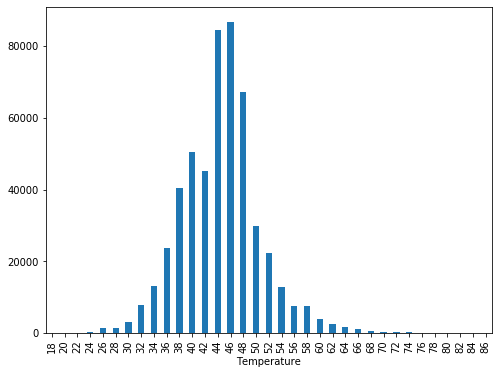

In [ ]:
#@title Cpu temperature samples (every 1min during a job)
cpu_laser_df = cpu_df.loc[cpu_df['data_state'] == 'laser']
total_laser_hours = cpu_laser_df['data_dur'].sum()/3600

num_snr = cpu_laser_df['snr'].nunique()
print('Number of different Mr Beams: {}'.format(num_snr))

temp_df = json_normalize(cpu_laser_df['data_temp'].tolist())

print('Number of jobs: {}'.format(len(temp_df)))
temp_df = pd.DataFrame(temp_df.sum()).reset_index()
temp_df.columns = ['Temperature', 'count']

temp_df = temp_df.sort_values('Temperature')
num_samples = temp_df['count'].sum()
print('Number of samples: {}  |  Laser hours: {:.2f}h'.format(num_samples, total_laser_hours))
# print(temp_df)
pie = temp_df.plot.bar(x='Temperature', y='count', figsize=(8,6), legend=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


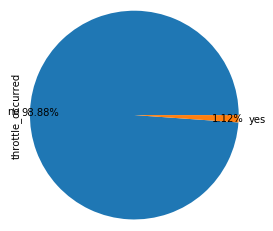

In [ ]:
#@title Jobs with throttle warnings
# for LASER STATE
cpu_laser_df = cpu_df.loc[cpu_df['data_state'] == 'laser']

cpu_laser_df['throttle_occurred'] = np.where(cpu_laser_df['data_throttle'], 'yes', 'no')
cpu_laser_df['throttle_occurred'].value_counts().plot.pie(radius=1.2, autopct='%1.2f%%', pctdistance=0.9)


 ### Dirt level (fan RPM test) --> Use with only 1 SNR

In [ ]:
#@title prod_job_fan_rpm_test
def prod_job_fan_rpm_test(datastore_client):
  query = datastore_client.query(kind='job')
  # query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'fan_rpm_test')
  query.add_filter('snr', '=', '000000003D2B6CF4-2U')
  
  return list(query.fetch())

prod_job_fan_rpm_test = prod_job_fan_rpm_test(datastore_client)

In [ ]:
# @title rpm_df
rpm_df = pd.DataFrame(prod_job_fan_rpm_test)


# FROM_DATE = datetime(2019, 12, 10, tzinfo=None)
# TO_DATE = datetime.now()
# rpm_df.sort_values(by=['ts'])


# Apply timeframe and get date from ts
rpm_df['date'] = pd.to_datetime(rpm_df['ts'], unit='s')
rpm_df = rpm_df[(rpm_df['date'] > FROM_DATE) & (rpm_df['date'] < TO_DATE)]
rpm_df['date'] = rpm_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
rpm_df['data_rpm_val'] = rpm_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('rpm_val'))

In [ ]:
alt.Chart(rpm_df).mark_bar().encode(
  x='ts',
  y='data_rpm_val',
).interactive()

alt.Chart(...)

In [ ]:
#@title Fan rpm values in test
num_snr = rpm_df['snr'].nunique()
print('Number of different Mr Beams: {}'.format(num_snr))
print('Number of jobs: {}'.format(len(rpm_df)))

alt.Chart(rpm_df).mark_bar().encode(
    alt.X("data_rpm_val:Q", bin=alt.Bin(maxbins=50)),
    y='count()',
)

Number of different Mr Beams: 1
Number of jobs: 443


alt.Chart(...)

### Dust level at the beginning of a job (progress = 0)

In [ ]:
#@title prod_job_progress
def prod_job_progress(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'p_progress')
  
  return list(query.fetch())

prod_job_progress = prod_job_progress(datastore_client)

In [ ]:
# @title progress_df
progress_df = pd.DataFrame(prod_job_progress)

# Apply timeframe and get date from ts
progress_df['date'] = pd.to_datetime(progress_df['ts'], unit='s')
progress_df = progress_df[(progress_df['date'] > FROM_DATE) & (progress_df['date'] < TO_DATE)]
progress_df['date'] = progress_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
progress_df['data_dv'] = progress_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('dv'))
progress_df['data_p'] = progress_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('p'))

# print(len(progress_df.loc[progress_df['data_p'] >= 60]))
print(len(progress_df.loc[progress_df['data_p'] == 0].loc[progress_df['data_dv'] >= 0.38]))

filtered_df = progress_df.loc[progress_df['data_p'] == 0].loc[progress_df['data_dv'] >= 0.38]
filtered_df = filtered_df.sort_values(by=['ts'], ascending=False).drop_duplicates(subset=['snr'])
print(len(filtered_df))
filtered_df
# num_snr = filtered_df['snr'].nunique()
# print(num_snr)


#Connectivity

### Sessions with internet connection

In [ ]:
#@title prod_device_internet_connection
def prod_device_internet_connection(datastore_client):
  query = datastore_client.query(kind='device')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'internet_connection')
  
  return list(query.fetch())

prod_device_internet_connection = prod_device_internet_connection(datastore_client)

In [ ]:
#@title internet_df

internet_df = pd.DataFrame(prod_device_internet_connection)

# Apply timeframe and get date from ts
internet_df['date'] = pd.to_datetime(internet_df['ts'], unit='s')
internet_df = internet_df[(internet_df['date'] > FROM_DATE) & (internet_df['date'] < TO_DATE)]
internet_df['date'] = internet_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
internet_df['internet'] = internet_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('connection'))

# Number of different Mr Beams for this timeframe
num_snr = internet_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

Number of different Mr Beams for this timeframe: 313


   internet  num_connected
0     False            902
1      True           6849


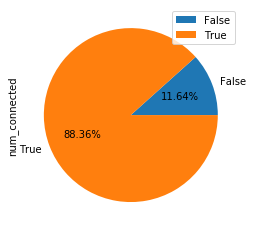

In [ ]:
#@title Sessions with internet connection
result_overall = internet_df.groupby(['internet']).size().reset_index(name='num_connected')

print(result_overall)
plot = result_overall.plot.pie(y='num_connected', labels=result_overall['internet'], autopct='%1.2f%%')


### Connections state

In [ ]:
#@title prod_connect_state
def prod_connect_state(datastore_client):
  query = datastore_client.query(kind='connectivity')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'connections_state')
  
  return list(query.fetch())

prod_connect_state = prod_connect_state(datastore_client)

In [ ]:
#@title state_df

state_df = pd.DataFrame(prod_connect_state)

# Apply timeframe and get date from ts
state_df['date'] = pd.to_datetime(state_df['ts'], unit='s')
state_df = state_df[(state_df['date'] > FROM_DATE) & (state_df['date'] < TO_DATE)]
state_df['date'] = state_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
state_df['data_wired'] = state_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('wired'))
state_df['data_wifi'] = state_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('wifi'))
state_df['data_ap'] = state_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('ap'))

# Number of different Mr Beams for this timeframe
num_snr = state_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(len(state_df)))

Number of different Mr Beams for this timeframe: 10847


state
wifi        4156
none        2067
eth+ap      1779
ap          1372
eth+wifi    1118
eth          355
Name: state, dtype: int64

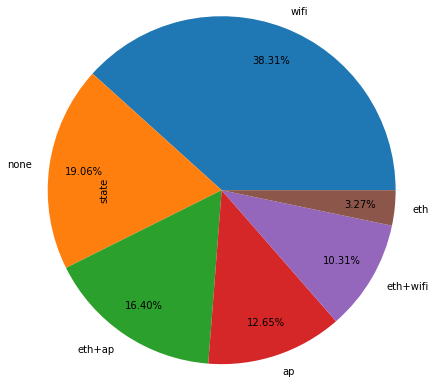

In [ ]:
#@title Connections state per session

def combinations(row):
    comb = []
    if row['data_wired']:
        comb.append('eth')
    if row['data_wifi']:
        comb.append('wifi')
    if row['data_ap']:
        comb.append('ap')
    if not row['data_wired'] and not row['data_wifi'] and not row['data_ap']:
        comb.append('none')

    return '+'.join(comb)

# grouped_formats = designs_df.groupby(['job_id'])['format'].apply(','.join).reset_index()
state_df['state'] = state_df.apply(combinations, axis=1)

# print('Number of jobs: {}'.format(len(grouped_formats)))

states = state_df.groupby(['state'])['state'].count().sort_values(ascending=False)
display(states)
states.plot.pie(labels=states.index.values, figsize=(4,4), radius=2, autopct='%1.2f%%', pctdistance=0.8)

#Materials

In [ ]:
#@title prod_job_material 
# QUERY

def prod_job_material(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('e', '=', 'material')
  query.add_filter('environment', '=', 'PROD')

  return list(query.fetch())

prod_job_material = prod_job_material(datastore_client)

In [ ]:
#@title PRESET_MATERIALS (add new materials here)
PRESET_MATERIALS = ['Acrylic', 
                    'Anodized Aluminum', 
                    'Balsa Wood', 
                    'Bamboo', 
                    'Cardboard, corrugated single wave',
                    'Cardboard, corrugated double wave', 
                    'Cork', 
                    'Finn Cardboard', 
                    'Felt', 
                    'Foam',
                    'Foam Rubber', 
                    'Grey Cardboard', 
                    'Jersey Fabric', 
                    'Kraftplex', 
                    'Kraftplex (wave)', 
                    'Leather', 
                    'Mirror',
                    'Paper', 
                    'Plywood Poplar', 
                    'Plywood Birch', 
                    'Polypropylene', 
                    'Slate', 
                    'Vegan Leather', 
                    'Wellboard', 
                    'N/A']

In [ ]:
#@title material_df & preset_df
material_df = pd.DataFrame(prod_job_material)

# Apply timeframe and get date from ts
material_df['date'] = pd.to_datetime(material_df['ts'], unit='s')
material_df = material_df[(material_df['date'] > FROM_DATE) & (material_df['date'] < TO_DATE)]
material_df['date'] = material_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
material_df['material_key'] = material_df['data'].apply(extract_value_from_data_struct, args=('material_key',))
material_df['color'] = material_df['data'].apply(extract_value_from_data_struct, args=('color',))
material_df['thickness_mm'] = material_df['data'].apply(extract_value_from_data_struct, args=('thickness_mm',))

# Separate preset materials from custom materials
custom_df = material_df.loc[~material_df['material_key'].isin(PRESET_MATERIALS)] 
material_df.loc[~material_df['material_key'].isin(PRESET_MATERIALS), 'material_key'] = 'Custom'

                         material_key  num_jobs
7                              Custom     10154
20                     Plywood Poplar      5788
19                      Plywood Birch      2752
18                              Paper      2497
3                              Bamboo      1714
8                                Felt      1694
14                          Kraftplex      1323
5   Cardboard, corrugated single wave      1054
9                      Finn Cardboard       812
16                            Leather       753
2                          Balsa Wood       746
11                        Foam Rubber       670
4   Cardboard, corrugated double wave       487
0                             Acrylic       443
23                      Vegan Leather       439
13                      Jersey Fabric       419
21                      Polypropylene       402
1                   Anodized Aluminum       388
12                     Grey Cardboard       372
22                              Slate   

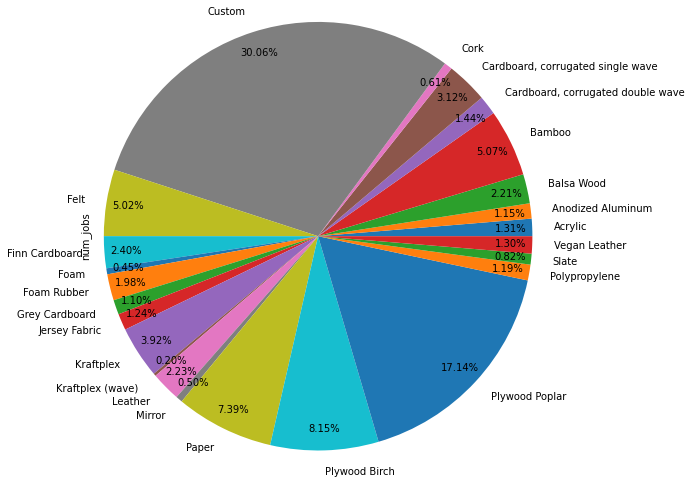

In [ ]:
#@title Material distribution
material_distribution = material_df.groupby(['material_key']).size().reset_index(name='num_jobs')

print(material_distribution.sort_values('num_jobs', ascending=False))
material_distribution.plot.pie(y='num_jobs', labels=material_distribution['material_key'], figsize=(8,30), radius=1.2, autopct='%1.2f%%', pctdistance=0.9, legend=False)


In [ ]:
#@title Top 20 custom materials 
custom_distribution = custom_df.groupby(['material_key']).size().reset_index(name='num_jobs')
print(custom_distribution.sort_values('num_jobs', ascending=False).head(20))


                      material_key  num_jobs
554                schneidebretter       610
87     birke schneider maskierband       469
268   liebst*cke schild birkenholz       342
381              my finn cardboard       266
344                 my bamboo wood       228
72           bambus bretter gravur       180
274                        magnete       170
403                   my kraftplex       148
481            my sperrholz pappel       147
472  my sperrholz (aus pappelholz)       145
84                birke liebst*cke       141
220                  korkkikankaat       133
383                   my finnpappe       131
432                       my paper       129
111                     cube&orbit       128
195                  holzbrettchen       126
276                markieren pappe       121
222                      kraftpack        99
473             my sperrholz birke        98
448              my plywood poplar        97


###Engraving time optimization mode

In [ ]:
#@title
# QUERY

# def prod_conv_eng(datastore_client):
#   query = datastore_client.query(kind='job')
#   query.add_filter('environment', '=', 'PROD')
#   query.add_filter('e', '=', 'conv_eng')

#   return list(query.fetch())

if 'prod_job_conv_eng' not in locals().keys():
  prod_job_conv_eng = prod_job_conv_eng_query(datastore_client)

In [ ]:
#@title

# PIE CHART
optimization_mode_count = dict()
for job in prod_conv_eng:
  if 'data' in job:
    mode = job['data'][0]['engraving_mode']
    if mode in optimization_mode_count: 
        optimization_mode_count[mode] += 1
    else: 
        optimization_mode_count[mode] =1

print(optimization_mode_count)
labels = ["{mode} ({count})".format(mode=key, count=value)  for key, value in optimization_mode_count.items()]
modes = optimization_mode_count.values()

plt.pie(modes, labels=labels, startangle=45, 
#         radius=2,
        autopct = '%1.2f%%')

plt.title('Engraving time optimization mode')
plt.show()

# Design Files

In [ ]:
#@title prod_job_design_file

def prod_job_design_file(datastore_client):
  query = datastore_client.query(kind='job')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'design_file')

  return list(query.fetch())

prod_job_design_file = prod_job_design_file(datastore_client)

NameError: ignored

In [ ]:
#@title designs_df

designs_df = pd.DataFrame(prod_job_design_file)
# jobs_df.replace(to_replace=[None], value='no_info', inplace=True)

# Apply timeframe and get date from ts
designs_df['date'] = pd.to_datetime(designs_df['ts'], unit='s')
designs_df = designs_df[(designs_df['date'] > FROM_DATE) & (designs_df['date'] < TO_DATE)]
designs_df['date'] = designs_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
designs_df['format'] = designs_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('format'))
designs_df['dim_x'] = designs_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('dim_x'))
designs_df['dim_y'] = designs_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('dim_y'))

# Caculate area of the design
designs_df['dim_x'] = designs_df['dim_x'].str.extract(r'(\d+)', expand=True).astype(float)
designs_df['dim_y'] = designs_df['dim_y'].str.extract(r'(\d+)', expand=True).astype(float)
designs_df['area'] = designs_df['dim_x']*designs_df['dim_y']

# Number of different Mr Beams for this timeframe
num_snr = designs_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))
print('Number of files: {}'.format(len(designs_df)))

NameError: ignored

### Formats

In [ ]:
#@title Formats of unique files

formats = designs_df.groupby(['format'])['format'].count()
print(formats)
formats.plot.pie(labels=formats.index.values, figsize=(4,4), radius=2, autopct='%1.2f%%', pctdistance=0.8);

NameError: ignored

In [ ]:
#@title Combinations of formats in a job

def combinations(row):
    comb = []
    if 'quicktext' in row['format']:
        comb.append('qt')
    if 'quickshape' in row['format']:
        comb.append('qs')
    if 'image' in row['format']:
        comb.append('img')
    if 'svg' in row['format']:
        comb.append('svg')
    if 'dxf' in row['format']:
        comb.append('dxf')

    return '+'.join(comb)

grouped_formats = designs_df.groupby(['job_id'])['format'].apply(','.join).reset_index()
grouped_formats['combination'] = grouped_formats.apply(combinations, axis=1)

print('Number of jobs: {}'.format(len(grouped_formats)))

format_groups = grouped_formats.groupby(['combination'])['combination'].count().sort_values(ascending=False)
print(format_groups)
plot_me=group_low_values(format_groups, threshold=200, replace_name="other")
plot_me.plot.pie(labels=plot_me.index.values, figsize=(4,4), radius=2, autopct='%1.2f%%', pctdistance=0.8)
del plot_me, format_groups

NameError: ignored

### Dimensions

In [ ]:
#@title x, y and area (mm, mm2)

designs_df[['dim_x','dim_y','area']].describe()

# Maintenance

In [ ]:
#@title prod_device_usage

def prod_device_usage(datastore_client):
  query = datastore_client.query(kind='device')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'mrbeam_usage')

  return list(query.fetch())

prod_device_usage = prod_device_usage(datastore_client)

In [ ]:
#@title usage_df

usage_df = pd.DataFrame(prod_device_usage)

# Apply timeframe and get date from ts
usage_df['date'] = pd.to_datetime(usage_df['ts'], unit='s')
usage_df = usage_df[(usage_df['date'] > FROM_DATE) & (usage_df['date'] < TO_DATE)]
usage_df['date'] = usage_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
usage_df['data_action'] = usage_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('action'))

# Number of different Mr Beams for this timeframe
num_snr = usage_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

Number of different Mr Beams for this timeframe: 491


data_action  reset_carbon_filter  ...  reset_prefilter
date                              ...                 
2020-01-01                     4  ...               15
2020-02-01                     1  ...                5
2020-03-01                     7  ...               20
2020-04-01                     3  ...               18
2020-05-01                     4  ...               25
2020-06-01                     9  ...               20
2020-07-01                    13  ...               34
2020-08-01                     7  ...               50
2020-09-01                     8  ...               29

[9 rows x 4 columns]

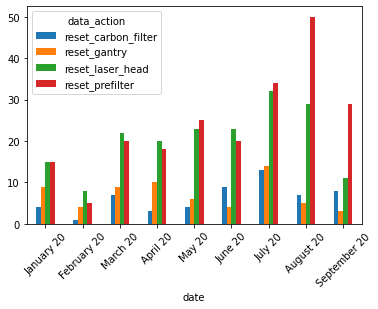

In [ ]:
#@title Number of usage resets per month
usage_df = usage_df[usage_df['data_action'] != 'job_finished']
usage_df['date'] = usage_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)

usage_crosstab = pd.crosstab(usage_df['date'],usage_df['data_action'])
display(usage_crosstab)

ax = usage_crosstab.plot.bar()
ax.set_xticklabels(usage_crosstab.index.strftime("%B %y"), rotation=45);

#iobeam

###HW malfunctions

In [ ]:
#@title prod_hw_malfunction

def prod_hw_malfunction(datastore_client):
  query = datastore_client.query(kind='iobeam')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'hw_malfunction')
  return list(query.fetch())

prod_hw_malfunction = prod_hw_malfunction(datastore_client)

In [ ]:
#@title malf_df
malf_df = pd.DataFrame(prod_hw_malfunction)

# Apply timeframe and get date from ts
malf_df['date'] = pd.to_datetime(malf_df['ts'], unit='s')
malf_df = malf_df[(malf_df['date'] > FROM_DATE) & (malf_df['date'] < TO_DATE)]
malf_df['date'] = malf_df['date'].dt.normalize()

# Extract data from list
malf_df['data'] = malf_df['data'].str[0]

# Extract values from data
malf_df = pd.json_normalize(malf_df['data'])

In [ ]:
malf_df

plugin_version  ...    compressor.msg
0          0.7.12  ...               NaN
1          0.7.12  ...               NaN
2          0.7.12  ...               NaN
3          0.7.12  ...               NaN
4          0.7.12  ...               NaN
5          0.7.12  ...               NaN
6          0.7.12  ...               NaN
7          0.7.12  ...               NaN
8          0.7.12  ...               NaN
9          0.7.12  ...               NaN
10         0.7.12  ...  compressor_rpm_0
11         0.7.12  ...               NaN
12         0.7.12  ...               NaN

[13 rows x 4 columns]

###Communication errors

In [ ]:
#@title prod_comm_errors

def prod_comm_errors(datastore_client):
  query = datastore_client.query(kind='iobeam')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'communication_errors')
  return list(query.fetch())

prod_comm_errors = prod_comm_errors(datastore_client)

In [ ]:
#@title comm_df
comm_df = pd.DataFrame(prod_comm_errors)

# Apply timeframe and get date from ts
comm_df['date'] = pd.to_datetime(comm_df['ts'], unit='s')
comm_df = comm_df[(comm_df['date'] > FROM_DATE) & (comm_df['date'] < TO_DATE)]
comm_df['date'] = comm_df['date'].dt.normalize()

# Extract data from list
comm_df['data'] = comm_df['data'].str[0]

# Extract values from data
comm_df = pd.json_normalize(comm_df['data'])

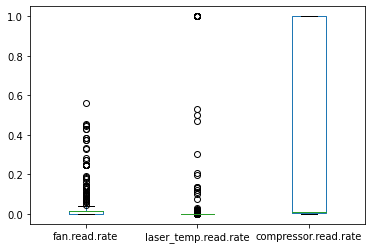

In [ ]:
#@title Read error rates
comm_df[['fan.read.rate', 'laser_temp.read.rate', 'compressor.read.rate']].plot.box()

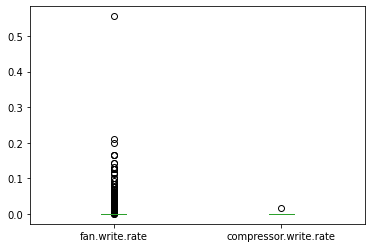

In [ ]:
#@title Write error rates
comm_df[['fan.write.rate', 'compressor.write.rate']].plot.box()

#Errors

###List of all errors

In [ ]:
#@title prod_log_events

def prod_log_events(datastore_client):
  query = datastore_client.query(kind='log')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'log_event')
  return list(query.fetch())

prod_log_events = prod_log_events(datastore_client)

In [ ]:
#@title mrbeamplugin_df & iobeam_df & leds_df
logs_df = pd.DataFrame(prod_log_events)

# Apply timeframe and get date from ts
logs_df['date'] = pd.to_datetime(logs_df['ts'], unit='s')
logs_df = logs_df[(logs_df['date'] > FROM_DATE) & (logs_df['date'] < TO_DATE)]
logs_df['date'] = logs_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
logs_df['component'] = logs_df['data'].apply(extract_value_from_data_struct, args=('component',))
logs_df['component_v'] = logs_df['data'].apply(extract_value_from_data_struct, args=('component_version',))
logs_df['msg'] = logs_df['data'].apply(extract_value_from_data_struct, args=('msg',))

logs_df['component_v'] = logs_df['component_v'].apply(lambda x: version.parse(x))

mrbeamplugin_df = logs_df[logs_df['component'] == 'mrbeam']
iobeam_df = logs_df[logs_df['component'] == 'iobeam']
leds_df = logs_df[logs_df['component'] == 'mrbeam_ledstrips']

In [ ]:
# Filter old records (only show from this version on)
SINCE_MRBEAMPLUGIN_V = '0.6.10'
SINCE_IOBEAM_V = '0.7.0'

In [ ]:
#@title List of errors in MrBeamPlugin
pd.options.mode.chained_assignment = None

error_msgs = [
  "Invalid or too old fan data from iobeam",
  "is_temperature_recent(): Laser temperature too old",
  "Conversion error (I/O operation failed.)",
  "Fan command responded error",
  "on_event() Error Event! Message: GRBL: error: Alarm lock",
  "cooling_stop() Laser temperature exceeded limit",
  "Received invalid laser head data from iobeam - invalid power calibrations data",
  "analytics file upload was not successful",
  "SYNCing clogged! Clearing commands in AccLineBuffer",
  "FLUSHing clogged! Clearing commands in AccLineBuffer: is_dirty: True",
  "_handle_status_report() Unpausing since we got status 'Idle' from grbl.",
  "Exception in _monitor_loop: invalid literal for float()",
  "GRBL Settings count incorrect",
  "_handle_status_report() Override pause since we got status 'Queue' from grbl.",
  "_handle_status_report() Pausing since we got status 'Queue' from grbl.",
  "_handle_status_report() Unpausing since we got status 'Idle' from grbl.",
  "Unpausing since we got status 'Run' from grbl.",
  "on_event() Error Event! Message: GRBL: error: Alarm lock",
  "Exception in _dataurl_to_img()",
  "Error when calculating the job duration estimation",
  "Failed to send fan command to iobeam",
  "GRBL Settings",
  "Fan error: data too old.",
  "Fan error: rpm:"
]

# Filter old versions
mrbeamplugin_df = mrbeamplugin_df[mrbeamplugin_df['component_v'] >= version.parse(SINCE_MRBEAMPLUGIN_V)]

# Standarize error messages
for std_msg in error_msgs:
  mrbeamplugin_df.loc[mrbeamplugin_df['msg'].str.contains(std_msg, regex=False),'msg'] = std_msg

# Group by version and msg 
mrbeamplugin_errors = mrbeamplugin_df.groupby(['component_v', 'msg']).size().to_frame('occurrences').sort_values(["component_v", "occurrences"], ascending=False)

# To see all the message string, add 'display.max_colwidth' as None
with pd.option_context('display.max_rows', None, 'display.max_columns', None): #, 'display.max_colwidth', None):
    print(mrbeamplugin_errors)


                                                                occurrences
component_v msg                                                            
0.7.5       _handle_status_report() Unpausing since we got ...         1267
            _handle_status_report() Override pause since we...          885
            _handle_status_report() Pausing since we got st...          268
            SYNCing clogged! Clearing commands in AccLineBu...          218
            Unpausing since we got status 'Run' from grbl.              198
            Handled exception in picamera: error, /home/pi/...          169
            IoBeamHandler not able to connect to socket /va...          114
             PiCameraMMALError : Camera connection error                 54
            Received invalid laser head data from iobeam - ...           36
            on_event() Error Event! Message: GRBL: error: N...           33
            GRBL: Machine Limit Hit. Please reset the machi...           27
            

In [ ]:
#@title List of errors in iobeam
pd.options.mode.chained_assignment = None

error_msgs = [
  "Compressor malfunction",
  "KeyError in loop()"
]

# Filter old versions
iobeam_df = iobeam_df[iobeam_df['component_v'] >= version.parse(SINCE_IOBEAM_V)]

# Standarize error messages
for std_msg in error_msgs:
  iobeam_df.loc[iobeam_df['msg'].str.contains(std_msg, regex=False),'msg'] = std_msg

# Group by version and msg 
iobeam_errors = iobeam_df.groupby(['component_v', 'msg']).size().to_frame('occurrences').sort_values(["component_v", "occurrences"], ascending=False)

# To see all the message string, add 'display.max_colwidth' as None
with pd.option_context('display.max_rows', None, 'display.max_columns', None): #'display.max_colwidth', None):
    print(iobeam_errors)

                                                                occurrences
component_v msg                                                            
0.7.11      IOError during I2C read: [Errno 121] Remote I/O...           85
            Error during I2C initialization!                              7
            Compressor malfunction                                        4
0.7.9       IOError during I2C read: [Errno 5] Input/output...          489
            IOError during I2C read: [Errno 121] Remote I/O...          175
            Can not import mrb_hw_info                                   75
            Error during I2C initialization!                             73
            TypeError in loop(): 'NoneType' object has no a...           20
            KeyError in loop()                                           15
            Compressor malfunction                                       10
            Exception in _scan_i2c_devices_smbus():                       1
0.7.8       

In [ ]:
#@title List of errors in MrBeamLedStrips
pd.options.mode.chained_assignment = None

error_msgs = [

]

# Filter old versions
# iobeam_df = iobeam_df[iobeam_df['component_v'] >= version.parse(SINCE_IOBEAM_V)]

# Standarize error messages
for std_msg in error_msgs:
  leds_df.loc[leds_df['msg'].str.contains(std_msg, regex=False),'msg'] = std_msg

# Group by version and msg 
leds_errors = leds_df.groupby(['component_v', 'msg']).size().to_frame('occurrences').sort_values(["component_v", "occurrences"], ascending=False)

# To see all the message string, add 'display.max_colwidth' as None
with pd.option_context('display.max_rows', None, 'display.max_columns', None): #'display.max_colwidth', None):
    print(leds_errors)

                                                                occurrences
component_v msg                                                            
0.1.26      Unknown state: ShutdownPrepareCancel                          9
0.1.25      Unknown state: ShutdownPrepareCancel                         28
            Got an error while processing message from clie...            1
0.1.24      Unknown state: ShutdownPrepareCancel                        213
            Got an error while processing message from clie...            7
0.1.23      Unknown state: ShutdownPrepareCancel                         53
            Unknown state: rollback                                       5
0.1.22      Unknown state: ShutdownPrepareCancel                         20
            Unknown state: rollback                                      14
            Got an error while processing message from clie...            8
0.1.21      Unknown state: ShutdownPrepareCancel                        761
            

In [ ]:
#@title dev_log_events (change version)

def dev_log_events(datastore_client):
  query = datastore_client.query(kind='log')
  query.add_filter('environment', '=', 'DEV')
  query.add_filter('e', '=', 'log_event')
  query.add_filter('version_mrbeam_plugin', '=', '0.7.2.1')

  return list(query.fetch())

dev_log_events = dev_log_events(datastore_client)

In [ ]:
#@title List of errors in latest develop
develop_df = pd.DataFrame(dev_log_events)
develop_df['msg'] = develop_df['data'].apply(extract_value_from_data_struct, args=('msg',))

pd.options.mode.chained_assignment = None

error_msgs = [
]

# Standarize error messages
for std_msg in error_msgs:
  develop_df.loc[develop_df['msg'].str.contains(std_msg, regex=False),'msg'] = std_msg

# Group by version and msg 
develop_errors = develop_df.groupby('msg').size().to_frame('occurrences').sort_values('occurrences', ascending=False)

# To see all the message string, add 'display.max_colwidth' as None
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    print(develop_errors)


###GRBL

In [ ]:
#@title

# from operator import itemgetter

# PREPROCESS DATA
log_events = dict()
for log in prod_log_events:
  ts = log['ts']
  date_time = datetime.fromtimestamp(ts)
  if date_time > FROM_DATE and date_time < TO_DATE:
    msg = log['data'][0]['msg']

    if 'handle_error' in msg:
      msg = msg.replace('\n', ' ').replace('\r', '')
      component = log['data'][0]['component'] 
      plugin_v = log['data'][0]['component_version']

      if 'sw_tier' in log:
        sw_tier = log['sw_tier']
      else:
        sw_tier = None

      # Count occurrences
      if component not in log_events:
        log_events[component] = dict()

      if plugin_v not in log_events[component]:
        log_events[component][plugin_v] = dict()

      if sw_tier not in log_events[component][plugin_v]:
        log_events[component][plugin_v][sw_tier] = dict()

      if msg in log_events[component][plugin_v][sw_tier]: 
          log_events[component][plugin_v][sw_tier][msg] += 1
      else: 
          log_events[component][plugin_v][sw_tier][msg] =1

    
# PRINT 
for component in log_events:
  print("Component: {}".format(component)) 
  sorted_versions = dict(sorted(log_events[component].items(), reverse=True))
  
  for plugin_v in sorted_versions:
    print("    Plugin version: {}".format(plugin_v))
    
    for sw_tier in log_events[component][plugin_v]:
      print("        SW tier: {}".format(sw_tier))
      sorted_msgs = dict(sorted(log_events[component][plugin_v][sw_tier].items(), key=itemgetter(1), reverse=True))
  
      for msg, count in sorted_msgs.items():
        print("            {}: {}".format(count, msg))


###Camera

In [ ]:
#@title prod_camera_logs
# QUERY: all the camera logs for production

def prod_camera_logs(datastore_client):
  query = datastore_client.query(kind='log')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'camera')

  return list(query.fetch())

prod_camera_logs = prod_camera_logs(datastore_client)

Bad data :  20165
 None : 27961
 source port is already connected : 418
 'NoneType' object has no attribute 'outputs' : 316
 Timed out waiting for capture to end : 111
 Unable to enable port vc.ril.image_encode:out:0: Out of memory : 84
 Failed to set parameter 65553 to False: Argument is invalid : 7
 Failed to enable connection: Out of resources : 5


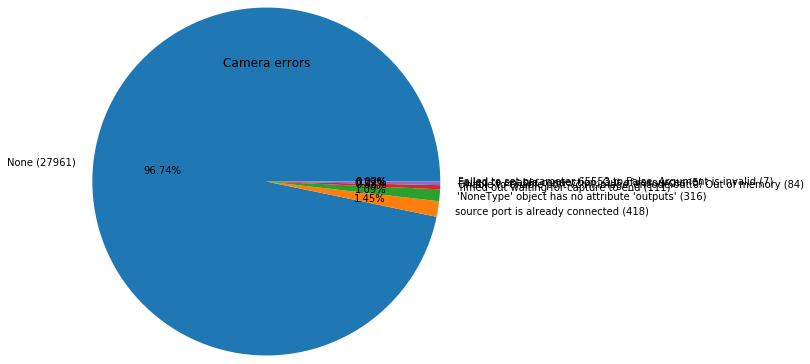

In [ ]:
#@title
# import matplotlib.pyplot as plt

# PIE CHARTS
fail_count = 0
camera_logs = dict()
for log in prod_camera_logs:
  if 'data' in log:
    if len(log['data']) == 0 or 'success' not in log['data'][0].keys():
      fail_count += 1
      continue
    success = log['data'][0]['success']
    err = log['data'][0]['err']
    if err in camera_logs: 
        camera_logs[err] += 1
    else: 
        camera_logs[err] =1

labels = ["{mode} ({count})".format(mode=key, count=value)  for key, value in camera_logs.items()]
errors = camera_logs.values()

# Errors
print("Bad data : ", fail_count)
print_all(camera_logs)
plt.pie(errors, labels=labels, startangle=0, 
        autopct = '%1.2f%%', radius=2)

plt.title('Camera errors')
plt.show()






In [ ]:
#@title
import altair as alt
import pandas as pd

camera_errors = dict()
for log in prod_camera_logs:
  if 'success' not in log['data'][0]:
    continue
  success = log['data'][0]['success']
  snr = log['snr']
  if success == True:
    if snr not in camera_errors:
      camera_errors[snr] = 0
  else:  
    if snr in camera_errors:
      camera_errors[snr] += 1
    else:
      camera_errors[snr] = 1

camera_df = pd.DataFrame(
    {'snr': list(camera_errors.keys()),
     'number of camera errors': list(camera_errors.values()),
    })

alt.Chart(camera_df).mark_bar().encode(
  x='snr',
  y='number of camera errors',
)

alt.Chart(...)

###HTTP self check

In [ ]:
#@title prod_http_self_check
# QUERY: all the camera logs for production

def prod_http_self_check(datastore_client):
  query = datastore_client.query(kind='device')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'http_self_check')

  return list(query.fetch())

prod_http_self_check = prod_http_self_check(datastore_client)

In [ ]:
#@title HTTP self check results (does not work with new data structure)
import matplotlib.pyplot as plt

# PIE CHARTS
self_checks = dict()
for check in prod_http_self_check:
  if 'data' in check:
    for interface in check['data'][0]:
      if 'response' in check['data'][0][interface]:
        response = check['data'][0][interface]['response']
        if response in self_checks:
          self_checks[response] +=1
        else:
          self_checks[response] = 1
      else:
        print(check['data'][0])


labels = ["{mode} ({count})".format(mode=key, count=value)  for key, value in self_checks.items()]
errors = self_checks.values()

# Errors
plt.pie(errors, labels=labels, startangle=45, 
        autopct = '%1.2f%%')

plt.title('HTTP self check responses')
plt.show()


In [ ]:
#@title
import altair as alt
import pandas as pd

self_checks = dict()
for check in prod_http_self_check:
  
  for interface in check['data'][0]:
    if 'response' in check['data'][0][interface]:
      response = check['data'][0][interface]['response']
      snr = check['snr']
      if response == 200:
        if snr not in self_checks:
          self_checks[snr] = 0
      else:  
        if snr in self_checks:
          self_checks[snr] += 1
        else:
          self_checks[snr] = 1
    else:
      print(check['data'][0])

camera_df = pd.DataFrame(
    {'snr': list(self_checks.keys()),
     'number of nok responses': list(self_checks.values()),
    })

alt.Chart(camera_df).mark_bar().encode(
  x='snr',
  y='number of nok responses',
)

# Frontend

### Job Done Dialog

In [ ]:
#@title Query : prod_frontend_welcome_start & prod_job_p_done for __job_done_df__
# def prod_frontend_job_done_dialog(datastore_client):
#   query = datastore_client.query(kind='frontend')
#   query.add_filter('environment', '=', 'PROD')
#   query.add_filter('e', '=', 'job_done_dialog')

#   return list(query.fetch())

if 'prod_job_done_dialog' not in locals().keys()
  prod_job_done_dialog = prod_job_done_dialog_query(datastore_client)
# job_done_df
job_done_df = pd.DataFrame(prod_job_done_dialog)
job_done_df['duration_s'] = job_done_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('dur'))


In [ ]:
#@title Duration of dialog (shown-closed)
num_snr = job_done_df['snr'].nunique()
print('Number of different Mr Beams: {}'.format(num_snr))
print('Number of jobs: {}'.format(len(job_done_df)))

boxplot = job_done_df.boxplot(column=['duration_s'])
boxplot.set_yscale('log')

# alt.Chart(job_done_df).mark_bar().encode(
#     alt.X("duration_s:Q", bin=alt.Bin(maxbins=100)),
#     y='count()',
# )


# For the dialogs that were open for less than 10min 
# dur_less_than_10min = job_done_df.loc[job_done_df['duration_s'] <= 10*60]
# alt.Chart(dur_less_than_10min).mark_bar().encode(
#     alt.X("duration_s:Q", bin=alt.Bin(maxbins=100)),
#     y='count()',
# )
# boxplot = dur_less_than_10min.boxplot(column=['duration_s'])

In [ ]:
#@title Delete job_done_df
del job_done_df

### Link clicks

In [ ]:
#@title Query: prod_frontend_link_click
def prod_frontend_link_click(datastore_client):
  query = datastore_client.query(kind='frontend')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'link_click')

  return list(query.fetch())

prod_frontend_link_click = prod_frontend_link_click(datastore_client)

In [ ]:
#@title click_df
click_df = pd.DataFrame(prod_frontend_link_click)

# Apply timeframe and get date from ts
click_df['date'] = pd.to_datetime(click_df['ts'], unit='s')
click_df = click_df[(click_df['date'] > FROM_DATE) & (click_df['date'] < TO_DATE)]
click_df['date'] = click_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
click_df['data_link'] = click_df['data'].apply(operator.itemgetter(0)).apply(operator.itemgetter('link'))

# Number of different Mr Beams for this timeframe
num_snr = click_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

Number of different Mr Beams for this timeframe: 190


data_link   carbon_filter_shop_link  ...  settings_maintenance_link
date                                 ...                           
2020-01-01                        3  ...                         22
2020-02-01                        3  ...                         16
2020-03-01                        1  ...                         33
2020-04-01                        9  ...                         25
2020-05-01                        5  ...                         33
2020-06-01                        3  ...                         28
2020-07-01                        3  ...                         46
2020-08-01                        9  ...                         70
2020-09-01                        1  ...                         27

[9 rows x 7 columns]

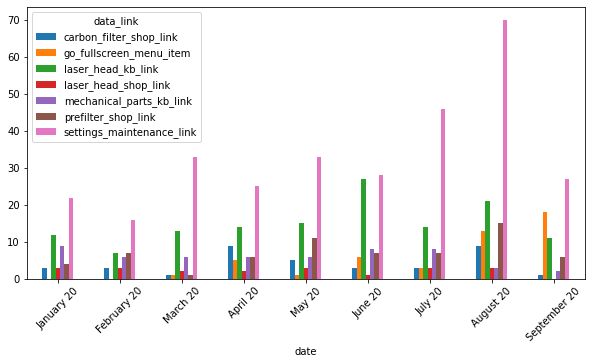

In [ ]:
#@title Number of clicks on links per month
click_df['date'] = click_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)

click_df = pd.crosstab(click_df['date'],click_df['data_link'])
display(click_df)

ax = click_df.plot.bar(figsize=(10,5))
ax.set_xticklabels(click_df.index.strftime("%B %y"), rotation=45);

### Repeat job

In [ ]:
#@title prod_frontend_repeat_job
def prod_frontend_repeat_job(datastore_client):
  query = datastore_client.query(kind='frontend')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'repeat_job')

  return list(query.fetch())

prod_frontend_repeat_job = prod_frontend_repeat_job(datastore_client)

In [ ]:
#@title repeat_df
repeat_df = pd.DataFrame(prod_frontend_repeat_job)

# Apply timeframe and get date from ts
repeat_df['date'] = pd.to_datetime(repeat_df['ts'], unit='s')
repeat_df = repeat_df[(repeat_df['date'] > FROM_DATE) & (repeat_df['date'] < TO_DATE)]
repeat_df['date'] = repeat_df['date'].dt.normalize()

# Number of different Mr Beams for this timeframe
num_snr = repeat_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

Number of different Mr Beams for this timeframe: 79


date
2020-04-01      7
2020-05-01    113
2020-06-01    123
2020-07-01     86
2020-08-01    147
2020-09-01    203
Freq: MS, Name: snr, dtype: int64


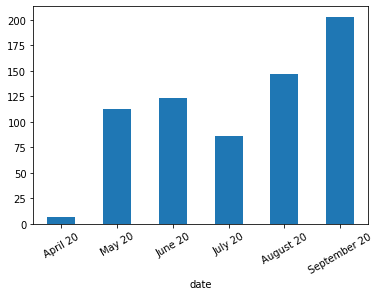

In [ ]:
#@title Number of repeated jobs (clicked on repeat job)
repeat_month_df = repeat_df.resample('MS', on='date')['snr'].count()# ['result_duration'].agg(['sum'])

print(repeat_month_df)
ax = repeat_month_df.plot(kind='bar')
ax.set_xticklabels(repeat_month_df.index.strftime('%B %y'), rotation=30);

### SVG properties

In [ ]:
#@title prod_frontend_svg
def prod_frontend_svg(datastore_client):
  query = datastore_client.query(kind='frontend')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'workingarea_place_svg_generic')

  return list(query.fetch())

prod_frontend_svg = prod_frontend_svg(datastore_client)

In [ ]:
#@title svg_df
svg_df = pd.DataFrame(prod_frontend_svg)

# Apply timeframe and get date from ts
svg_df['date'] = pd.to_datetime(svg_df['ts'], unit='s')
#click_df = click_df[(click_df['date'] > FROM_DATE) & (click_df['date'] < TO_DATE)]
svg_df['date'] = svg_df['date'].dt.normalize()

# Add new columns with data that is inside of [{}]
svg_df['node_types'] = svg_df['data'].apply(extract_value_from_data_struct, args=('node_types',))


# Number of different Mr Beams for this timeframe
num_snr = svg_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

Number of different Mr Beams for this timeframe: 359


In [ ]:
#@title List of SVG nodes
node_types = svg_df['node_types'].apply(pd.Series)
list_node_types = list(node_types.columns.values)
list_node_types

#Design store

In [57]:
#@title prod_store
def prod_store(datastore_client):
  query = datastore_client.query(kind='frontend')
  query.add_filter('environment', '=', 'PROD')
  query.add_filter('e', '=', 'store')

  return list(query.fetch())

prod_store = prod_store(datastore_client)

In [61]:
#@title store_df
store_df = pd.DataFrame(prod_store)

# Apply timeframe and get date from ts
store_df['date'] = pd.to_datetime(store_df['ts'], unit='s')
store_df = store_df[(store_df['date'] > FROM_DATE) & (store_df['date'] < TO_DATE)]
store_df['date'] = store_df['date'].dt.normalize()

# Extract action
store_df['action'] = store_df['data'].apply(extract_value_from_data_struct, args=('action',))
store_df['payload'] = store_df['data'].apply(extract_value_from_data_struct, args=('payload',))

# Number of different Mr Beams for this timeframe
num_snr = store_df['snr'].nunique()
print('Number of different Mr Beams for this timeframe: {}'.format(num_snr))

Number of different Mr Beams for this timeframe: 40


sorting
downloads_desc      22
price_asc            5
price_desc           4
upload_date_desc     8
Name: sorting, dtype: int64


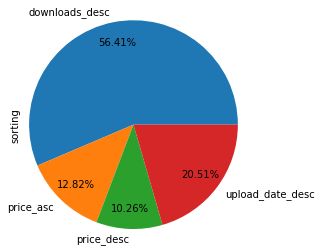

In [71]:
#@title Sorting criteria
sorting_df = store_df[store_df['action'] == 'sorting_selected']
sorting_df = pd.json_normalize(sorting_df['payload'])

sorting = sorting_df.groupby(['sorting'])['sorting'].count()
print(sorting)
sorting.plot.pie(labels=sorting.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);

category
              13
animals       11
birth          8
birthday       8
christmas      8
decoration    10
easter         8
jewellery     10
love           9
lyrics         8
skylines       8
tags           6
weddings      11
winter        10
Name: category, dtype: int64


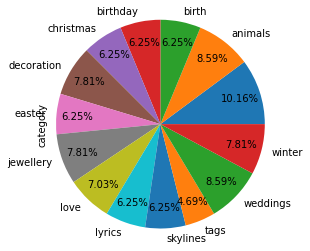

In [73]:
#@title Category
category_df = store_df[store_df['action'] == 'category_selected']
category_df = pd.json_normalize(category_df['payload'])

category = category_df.groupby(['category'])['category'].count()
print(category)
category.plot.pie(labels=category.index.values, figsize=(4,4), radius=1.2, autopct='%1.2f%%', pctdistance=0.8);

action      check_design  purchase  purchase_btn
date                                            
2020-09-01           176        38           109

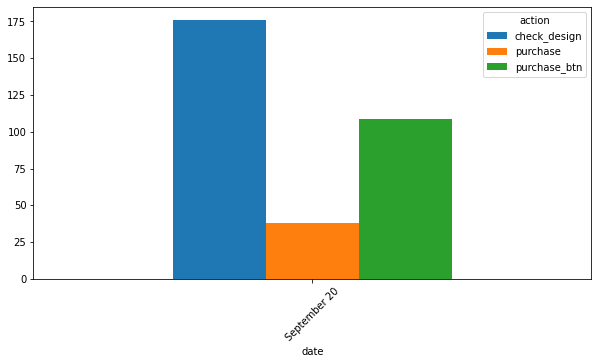

In [91]:
#@title Purchases & checked designs
purchase_df = store_df[(store_df['action'] == 'purchase') | (store_df['action'] == 'purchase_btn') | (store_df['action'] == 'check_design')]

purchase_df['date'] = purchase_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)

purchase = pd.crosstab(purchase_df['date'],purchase_df['action'])
display(purchase)

ax = purchase.plot.bar(figsize=(10,5))
ax.set_xticklabels(purchase.index.strftime("%B %y"), rotation=45);

message     Invalid authorization token or device serial  ...  No authorization token or device serial
date                                                      ...                                         
2020-09-01                                             6  ...                                        4

[1 rows x 3 columns]

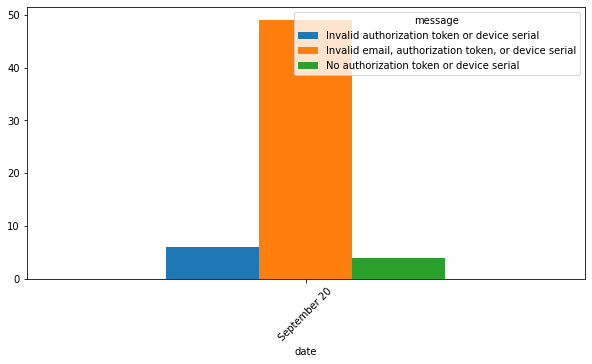

In [90]:
#@title Call errors
call_df = store_df[store_df['action'] == 'call_error']
call_df['date'] = call_df['date'] + pd.offsets.MonthEnd(n=0) - pd.offsets.MonthBegin(n=1)
call_df['message'] = call_df['payload'].apply(lambda x: x.get('message'))

call = pd.crosstab(call_df['date'],call_df['message'])
display(call)

ax = call.plot.bar(figsize=(10,5))
ax.set_xticklabels(call.index.strftime("%B %y"), rotation=45);

# Camera



In [ ]:
# @title Camera Queries

KEY_QUERY = ['legacy_vs_0_5', '0_6_4']
queries = dict(zip(KEY_QUERY, [('data.new.markers.NE.found', '>=', 0),
                              #  ('data.markers.NE.missed',    '>=', 1),
                               ('data.markers.NE.found',     '>=', 0)]))
# Download the data from the datastore
res = []
for k, q in queries.items():
  query = datastore_client.query(kind='log')
  query.add_filter(*q)
  res.append(pd.DataFrame(list(query.fetch())))
raw_frame = pd.concat(res)
raw_frame.drop_duplicates(['uptime','created', 'sid'], inplace=True, keep='first')
raw_frame['version_mrbeam_plugin'] = raw_frame['version_mrbeam_plugin'].apply(version.Version)
raw_frame = raw_frame[raw_frame['environment'].astype(str) == 'PROD']
dataframe_cols = ['version_mrbeam_plugin', 'snr', 'data', 'environment', 'sw_tier']
raw_frame = raw_frame.loc[:, dataframe_cols]

new.markers done	-- unique machines 37 -- samples 1532
legacy.markers done	-- unique machines 37 -- samples 1532
0.6.04.2 done		-- unique machines 33 -- samples 465
0.6.08 done		-- unique machines 56 -- samples 2231
0.6.11 done		-- unique machines 63 -- samples 3494
0.6.14 done		-- unique machines 55 -- samples 1692
0.7.0 done		-- unique machines 15 -- samples 180
0.7.1 done		-- unique machines 195 -- samples 6198
version 0.6.14 + : ratio of pictures sent to the user: 0.9130738635446997
                   Machines that rarely managed to send a picture:  1
version 0.7.1 + : ratio of pictures sent to the user: 0.939990561776312
                   Machines that rarely managed to send a picture:  2


min_brightness  avg_brightness  ...  ratio found  standard deviation
corner                                  ...                                 
NE          112.992358      137.721648  ...     0.866318            0.137387
NW          101.226226      126.315879  ...     0.834189            0.144071
SE          177.173542      210.786983  ...     0.858604            0.183345
SW          160.420120      195.785657  ...     0.854751            0.178570

[4 rows x 5 columns]

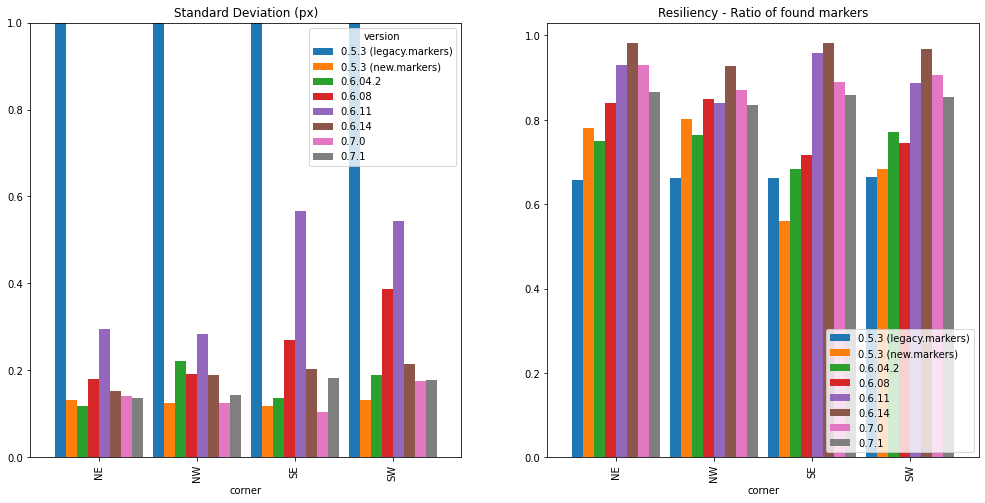

In [ ]:
#@title Marker Detection

def slice_versions(df:Union[pd.DataFrame, pd.Series], vmin=None, vmax=None, version_col='version_mrbeam_plugin'):
  ret = df.copy()
  not_this_release = version.parse('0.6.12')
  if vmin is not None:
    _vmin = version.parse(vmin) if type(vmin) is str else vmin
    ret = ret[ret[version_col] >= _vmin]
  if vmax is not None:
    _vmax = version.parse(vmax) if type(vmax) is str else vmax
    ret = ret[ret[version_col] <  _vmax]
  if vmin is not None and vmax is not None:
    if _vmin <= not_this_release <= _vmax:
      ret = ret[ret['version_mrbeam_plugin'] != not_this_release]
  return ret

data_depth_extract = dict(zip(KEY_QUERY, [1, 0]))
dataframes = {}
# Check version numbers
vers = ['0.6.04.2', '0.6.08', '0.6.11', '0.6.14', '0.7.0', '0.7.1']
for df_name, vmin, vmax in chain([[KEY_QUERY[0], '0.5.3', '0.6.4.2']],
                                 [[KEY_QUERY[1], _min, _max] for _min, _max in zip(vers,vers[1:]+[None])]):
  dataframes[vmin] = slice_versions(raw_frame, vmin, vmax)
  dataframes[vmin] = pd.concat([dataframes[vmin], 
                                series_with_json(dataframes[vmin]['data'], 
                                                    max_level=data_depth_extract[df_name])], 
                               axis='columns',
                               join='inner',
                               ignore_index=False)
index_names = ['version', 'serial_num', 'sample', 'corner']
columns = ['found', 'missed', 'ratio_found', 'num_pics', 'std_pos', 'avg_pos']
camera_df = {}
# Drop unusable data
dataframes['0.5.3'].dropna(subset=['new.markers', 'legacy.markers'], inplace=True)
for v in vers:
  dataframes[v].dropna(subset=['markers'], inplace=True)
# camera_df - convert the json data into subframes
## v0.5.3+
for k in ['new.markers', 'legacy.markers']:
  key = '0.5.3 (' + k + ')'
  camera_df[key] = pd.concat(
      {(snr, line): pd.DataFrame(entity).applymap(np.array).T
                    for snr, df in dataframes['0.5.3'].groupby('snr')
                    for line, entity in df[k].items()})
  print(k + ' done\t-- unique machines %s -- samples %s' % 
      (camera_df[key].index.get_level_values(0).nunique(),
       len(camera_df[key].index)//4))

## v0.6.4.2+
for v in vers:
  camera_df[v] = pd.concat(
      {(snr, line): pd.DataFrame(entity_dict).applymap(np.array).T
                    for snr, df in dataframes[v].groupby('snr')
                    for line, entity_dict in df['markers'].items()})
  print(str(v) + ' done\t\t-- unique machines %s -- samples %s' % 
        (camera_df[v].index.get_level_values(0).nunique(),
        len(camera_df[v].index)//4))

camera_df = pd.concat(camera_df, names=index_names)

# Ratio of pictures sent to the user / pictures taken
def means(vers):
  _means = dataframes[vers].groupby('snr').mean()
  _means['Ratio pics sent'] = _means['num_success_pics'] / _means['num_pics']
  mean_pics_sent = _means['Ratio pics sent'].mean()
  print("version "+vers+" + : ratio of pictures sent to the user:", mean_pics_sent)
  print("                   Machines that rarely managed to send a picture: ", 
        (_means['Ratio pics sent'] <=.2).sum())
  return _means

means('0.6.14')
means('0.7.1')

# Ratio of markers found per machine per session
camera_df['ratio found'] = camera_df['found'] / (camera_df['found'] + camera_df['missed'])
#   Average for each device
index_names.remove('sample')
averages = pd_reduce(camera_df, level=index_names)
averages.index.names = index_names
#   Average over each device
index_names.remove('serial_num')
averages = pd_reduce(averages, level=index_names)
averages.index.names = index_names
#   We are only interested in showing the norm of the std deviation. 
averages['standard deviation'] = averages['std_pos'].map(np.linalg.norm)
#   Plot the standard deviations and ratio of found markers
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 8))
for col, ax, title in [['standard deviation', ax1, 'Standard Deviation (px)'],
                       ['ratio found', ax2, 'Resiliency - Ratio of found markers']]:
  averages[col].unstack(level='version').plot(title=title, kind='bar', ax=ax, width=0.9)
ax2.legend(loc = 'lower right')
ax1.set_ylim(top=1)
# Show the DataFrame
show_these_cols = averages.columns.tolist()
for c in ['avg_pos', 'avg_color', 'marker_px_size', 'std_pos','found','missed']:
  show_these_cols.remove(c)
averages[show_these_cols].loc['0.7.1']

version 0.6.14 + : ratio of pictures sent to the user: 0.9130738635446997
                   Machines that rarely managed to send a picture:  1
version 0.7.1 + : ratio of pictures sent to the user: 0.939990561776312
                   Machines that rarely managed to send a picture:  2
Machines with camera problems in version 0.7.1 : 


settings_min_marker_size  ...  Ratio pics sent
snr                                            ...                 
00000000800BC034-2F                     350.0  ...              0.0
00000000AA3ED720-2U                     350.0  ...              0.0

[2 rows x 7 columns]

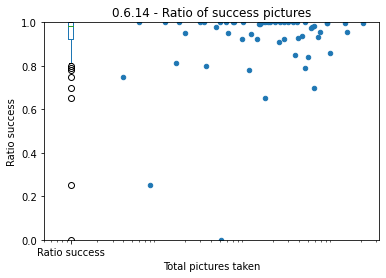

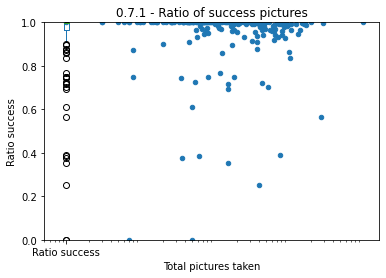

In [ ]:
#@title Successful pictures
_means ={}

for vers in ['0.6.14', '0.7.1']:
  res = {}
  _means[vers] = means(vers)
  for snr, val in _means[vers]['Ratio pics sent'].items():
    # if val < .3:
    _df = dataframes[vers]
    tot_pics = _df[_df['snr'] ==snr]['num_pics'].sum()
    res[snr] = {
        'Ratio success': val,
        'Total pictures taken': tot_pics
    }
  df = pd.DataFrame(res).T
  ax1 = df.plot(kind='scatter', x='Total pictures taken', y='Ratio success', logx=True)
  ax2 = df['Ratio success'].plot(kind='box', title=vers + ' - Ratio of success pictures', ylim=(0,1))

  # description = pd.DataFrame(df.describe())
  # idx = list(description.index)
  # idx[0] = 'number of devices'
  # description.index = idx
  # description
vers = '0.7.1'
print("Machines with camera problems in version " + vers + " : ")
_means[vers][_means[vers]['Ratio pics sent'] < 0.2]